In [3]:
import sys
# not best practice, but makes it easier to import from subdirectory
sys.path.insert(0, './lib')
sys.path.insert(0, './archive')

import experiment as exp
import plot
import predict

import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt
from hdf5storage import loadmat

import os
import math
import torch
import torchaudio
import pytorch_lightning as pl

import dynamic_strf.modeling as modeling
import dynamic_strf.estimate as estimate
import dynamic_strf.visualize as visualize

%load_ext autoreload
%autoreload 2

device = torch.device('cuda:0')

Invoking __init__.py for NDNT.utils


In [4]:
e = exp.load('is_multiexp_test02', experiment_location='experiments', datadir='Mdata')
e.trials.where(e.trials.name == 'cnim_scaffold2')

,null_adjusted_LL,num_filters,num_inh_percent,expt,kernel_widths,kernel_heights,copy_weights,freeze_weights,include_MUs,is_multiexp,modelstr,d2xt,l1,center,bcs,name,trial,mean_LLs
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,True,"32,16,8",0.75,expt04+expt05+expt06+expt07,"21,21,21","3,3,3",False,False,False,True,cnim_scaffold,0.01,0.0001,0.01,{'d2xt': 1},cnim_scaffold2,<experiment.Trial object at 0x7f6de8f74160>,0.285043
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
model = e.trials_where(name='cnim_scaffold2')[0].model
dataset = e.trials_where(name='cnim_scaffold2')[0].dataset

lazy loading dataset
Loading expt04
  Time embedding...
  Done.
Loading expt05
  Time embedding...
  Done.
Loading expt06
  Time embedding...
  Done.
Loading expt07
  Time embedding...
  Done.


In [6]:
dataset[0]

{'stim': tensor([ 0.,  1., -1., -1.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,
          1., -1.,  0.,  0.,  0.,  0.,  0., -1.,  1.,  1.,  0.,  0.,  1.,  0.,
         -1.,  1.,  0., -1.,  1.,  0., -1.,  1.,  0., -1., -1., -1.,  0.,  0.,
          1.,  0.,  1.,  1.,  0., -1., -1.,  0.,  0.,  1.,  1.,  0.,  1., -1.,
          0.,  0., -1.,  1.,  0.,  1.,  0., -1.,  1.,  1.,  1.,  1.,  0.,  0.,
          0.,  1.,  1.,  1.,  0.,  1., -1.,  0.,  1.,  0.,  0.,  1., -1.,  1.,
          0.,  0.,  1.,  0.,  0., -1.,  0.,  1., -1.,  0.,  1.,  0.,  0.,  1.,
          0.,  1.,  0., -1.,  0.,  1.,  0., -1.,  0.,  1.,  0.,  0.,  0., -1.,
         -1.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          1., -1.,  1.,  0.,  0.,  0.,  0., -1., -1.,  1., -1.,  1.,  0., -1.,
          0., -1.,  0.,  1.,  0.,  0.,  1., -1.,  0., -1.,  0.,  1.,  1.,  0.,
          0.,  1.,  1.,  0., -1.,  1.,  0., -1.,  1.,  1.,  1.,  0., -1., -1.,
          1.,  0.,  0.,  0.,  1., -1., -1., 

In [7]:
@torch.no_grad()
def dSTRF(model, x, chunk_size=1000, context_size=1000, verbose=0):
    """
    Estimate dynamic spectrotemporal receptive field (dSTRF) of a model for given input `x`.

    Arguments:
        mode: a pytorch model being analyzed. It should accept input of shape [time * in_channels]
            and return output of shape [time * out_channels].
        x: input of shape [time * in_channels].
        chunk_size: number of time samples to calculate dSTRF on simultaneously.
        context_size: length of dataset to use for calculating dSTRF.
        verbose: a boolean, indicating whether to print out progress status.
    
    Returns:
        dstrfs: a dSTRF tensor of shape [time * out_channels * time_lag * in_channels].
    """
    # Pad input such that output has same shape and is half-precision
    
    #x = torch.nn.functional.pad(x, (0, 0, context_size, 0)).half()
    def model_fx(x):
        with torch.cuda.amp.autocast():
            return model.NDN(x)[context_size:]

    dstrfs = []
    chunks = math.ceil((len(x) - context_size) / chunk_size)
    chunks = range(chunks)
    for chunk_idx in chunks:
        chunk_start = chunk_idx * chunk_size
        chunk_length = min(chunk_size + context_size, len(x) - chunk_start)

        # Jacobian has shape [time * channel * lag * frequency]
        jacobian = torch.autograd.functional.jacobian(
            model_fx, x[chunk_start:chunk_start+chunk_length]
        ).cpu()

        dstrfs.append( # dSTRF is of shape [time * channel * lag * frequency]
            torch.stack([j[:, t:t+context_size+1] for t, j in enumerate(jacobian)], dim=0)
        )
        del jacobian

    return torch.cat(dstrfs, dim=0) # shape [time * channel * lag * frequency]

In [8]:
dSTRF(model, dataset, context_size=1000)

TypeError: The inputs given to jacobian must be either a Tensor or a tuple of Tensors but the given inputs has type <class 'dict'>.

In [ ]:
inps = dataset.stim
context_size = 1000
def model_fx(x):
    with torch.cuda.amp.autocast():
        return model.NDN.networks[0].layers[0](x)

# Jacobian has shape [time * channel * lag * frequency]
jacobian = torch.autograd.functional.jacobian(
    model_fx, inps[:20], vectorize=True
).cpu()

In [ ]:
jacobian.shape

In [ ]:
fig = plt.figure(figsize=(15,5))
grid = plt.GridSpec(4, 5)
for i in range(4):
    for j in range(5):
        ax = fig.add_subplot(grid[i,j])
        mean_jacobian = torch.mean(jacobian[i, :, :], axis=0)
        mean_jacobian = torch.mean(mean_jacobian, axis=0)
        imin = torch.min(mean_jacobian.flatten())
        imax = torch.max(mean_jacobian.flatten())
        ax.imshow(mean_jacobian.detach().numpy().reshape(10, 36),
                         vmin=imin, vmax=imax,
                         interpolation='none',
                         cmap='gray',
                         origin='lower')

In [ ]:
# need to install pytorch 1.13 in order to use this
# jacrev = torch.func.jacrev(model.NDN.networks[0].layers[0], inps[0])

In [ ]:
output = model.NDN.networks[0].layers[0](inps[0])

In [ ]:
inps[0].shape, output.shape, jacobian.shape

In [ ]:
fig = plt.plot(jacobian[0, :, :].detach().numpy())

In [ ]:
# separate out excitatory and inhibitory weights
# get num_inh and num_filters from the layer, and separate out when this averaging

# TODO: load the Results object and make a video of the dSTRF for exc and inh over time.

num_filters = model.networks[0].layers[0].params['num_filters']
num_inh = model.networks[0].layers[0].params['num_inh']
num_exc = num_filters - num_inh
num_exc *= 36
num_inh *= 36

dstrf_exc = jacobian[0, :num_exc, :]
dstrf_inh = jacobian[0, num_exc:, :]

mean_exc_weights = torch.mean(jacobian[0, :num_exc, :], axis=0)
mean_inh_weights = torch.mean(jacobian[0, num_exc:, :], axis=0)

In [ ]:
num_exc, num_inh, jacobian.shape

In [ ]:
import matplotlib.pyplot as plt
imin = torch.min(mean_exc_weights.flatten())
imax = torch.max(mean_exc_weights.flatten())
plt.imshow(mean_exc_weights.detach().numpy().reshape(10, 36),
           vmin=imin, vmax=imax,
           interpolation='none',
           cmap='gray',
           origin='lower')

In [ ]:
import matplotlib.pyplot as plt
imin = torch.min(mean_inh_weights.flatten())
imax = torch.max(mean_inh_weights.flatten())
plt.imshow(mean_inh_weights.detach().numpy().reshape(10, 36),
           vmin=imin, vmax=imax,
           interpolation='none',
           cmap='gray',
           origin='lower')

In [ ]:
# from the tutorial
# https://nbviewer.org/github/naplab/DSTRF/blob/master/Examples/Tutorial.ipynb

In [ ]:
# Find maximum value for color axis
vmax = dstrf_exc.abs().max(dim=0)[0].max(dim=0)[0].quantile(0.90)

# Plot figure
plt.figure(figsize=(15, 2))
for i, t in enumerate([100, 200, 300, 400, 500]):
    plt.subplot(1, 5, i+1)
    plt.imshow(
        dstrf_exc[t].detach().numpy().reshape(10, 36), aspect='auto', cmap='gray', vmin=-vmax, vmax=vmax, origin='lower'
    )

    plt.xlabel('Time lag (ms)')
    if i == 0:
        plt.ylabel('Time lag', labelpad=-10)
    else:
        plt.yticks([])
plt.show()

## get the Jacobians through the predict function

In [859]:
model.networks[0].name

'core'

In [860]:
results = predict.predict(model, dataset=dataset[100:150], network_names_to_use=['core'])

In [861]:
results.jacobians[0]['core'][0].shape

torch.Size([1, 1152, 360])

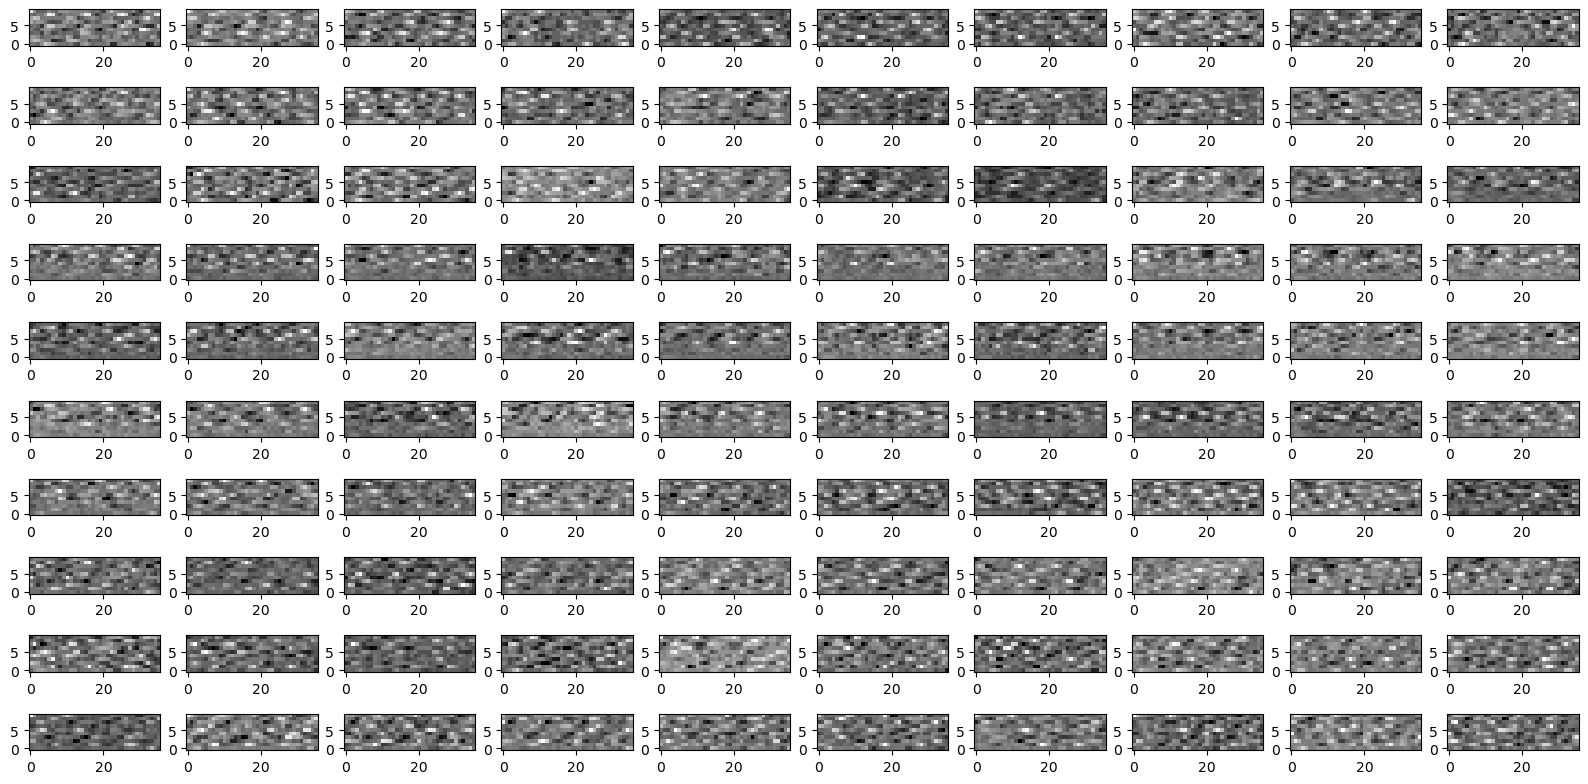

In [63]:
rows = 10
cols = 10
fig = plt.figure(figsize=(20,10))
grid = plt.GridSpec(rows, cols)
k = 0
for i in range(rows):
    for j in range(cols):
        jacobian = results.jacobians[k]['core'][0]
        ax = fig.add_subplot(grid[i,j])
        mean_jacobian = torch.mean(jacobian[0,:,:], axis=0)
        imin = torch.min(mean_jacobian.flatten())
        imax = torch.max(mean_jacobian.flatten())
        ax.imshow(mean_jacobian.detach().numpy().reshape(10, 36),
                  vmin=imin, vmax=imax,
                  interpolation='none',
                  cmap='gray',
                  origin='lower')
        k += 1

# results

In [349]:
start = 50
end = 550
results = predict.predict(model,
                          dataset=dataset[start-50:end+50],
                          network_names_to_use=['core'])

KeyboardInterrupt: 

In [151]:
for i in range(start, end):
    # for time 0 and layer 0 of the core network
    # get the stims
    stim = dataset[i]['stim'][0,:]
    
    # get the Jacobians for the different layers of the core network
    dstrf_excs = []
    dstrf_inhs = []
    for li in range(len(model.networks[0].layers)):
        # get the Jacobians for the inhibitory and excitatory weights
        num_filters = model.networks[0].layers[li].params['num_filters']
        num_inh = model.networks[0].layers[li].params['num_inh']
        num_exc = num_filters - num_inh
        num_exc *= 36
        num_inh *= 36
        jacobian = results.jacobians[i]['core'][0]
        dstrf_exc = torch.mean(jacobian[0, :num_exc, :], axis=0)
        dstrf_inh = torch.mean(jacobian[0, num_exc:, :], axis=0)
        dstrf_excs.append(dstrf_exc)
        dstrf_inhs.append(dstrf_inh)
    
    # get the predicted robs for neuron 0
    pred = results.pred[i-50:i+50, 1]
    robs = results.robs[i-50:i+50, 1]
        
    ## make the plot for a single frame including stim, prediction, and dSTRF
    rows = 5
    cols = 2
    fig = plt.figure(figsize=(10,10))
    grid = plt.GridSpec(rows, cols)
    
    ax_stim = fig.add_subplot(grid[0,:])
    ax_stim.imshow(stim.detach().numpy().reshape(36,10).T,
                   interpolation='none',
                   cmap='gray',
                   origin='lower')
    ax_stim.set_title('Stimulus')
    
    # plot the dstrfs for each layer
    for li in range(len(dstrf_excs)):
        # get the min and max values for the color axis
        imin_exc = torch.min(dstrf_excs[li].flatten())
        imax_exc = torch.max(dstrf_excs[li].flatten())
        imin_inh = torch.min(dstrf_inhs[li].flatten())
        imax_inh = torch.max(dstrf_inhs[li].flatten())
        
        ax_dstrf_exc = fig.add_subplot(grid[li+1,0])
        ax_dstrf_exc.imshow(dstrf_excs[li].detach().numpy().reshape(36,10).T,
                  vmin=imin_exc, vmax=imax_exc,
                  interpolation='none',
                  cmap='gray',
                  origin='lower')
        ax_dstrf_exc.set_title('dSTRF Exc Layer {}'.format(li))
        ax_dstrf_inh = fig.add_subplot(grid[li+1,1])
        ax_dstrf_inh.imshow(dstrf_inhs[li].detach().numpy().reshape(36,10).T,
                            vmin=imin_inh, vmax=imax_inh,
                            interpolation='none',
                            cmap='gray',
                            origin='lower')
        ax_dstrf_inh.set_title('dSTRF Inh Layer {}'.format(li))
    
    ax_robs = fig.add_subplot(grid[len(dstrf_excs)+2,:])
    ax_robs.plot(pred, c='r')
    ax_robs.plot(robs.detach().numpy(), c='b')
    ax_robs.axvline(x=50, color='r', linestyle='--')
    ax_robs.legend(['Predicted', 'Actual'], loc='upper right')
    eat = ax_robs.set_title('Predicted Robs')
    
    # ffmpeg requires that the digits start at 0
    plt.savefig(os.path.join('viz/dstrfs', f'frame-{i-50:04d}.png'))
    plt.close(fig)

In [154]:
# this doesn't work because it can't find the file
import ffmpeg
ffmpeg.input(
    f'viz/dstrfs/frame-%04d.png', framerate=10
).output(
    'dstrfs.mp4', r=60, pix_fmt='yuv420p'
).run(
    overwrite_output=True
)

ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/tmp/build/80754af9/ffmpeg_1587154242452/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100


(None, None)

In [207]:
os.system("ffmpeg -f image2 -r 5/1 -i ./viz/dstrfs/frame-%04d.png -vcodec mpeg4 -y output.mp4")

ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/tmp/build/80754af9/ffmpeg_1587154242452/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100


0

# make video for whole model

In [350]:
start2 = 50
end2 = 550
results2 = predict.predict(model,
                           dataset=dataset[start2-50:end2+50],
                           network_names_to_use=['core'])

In [351]:
results2.pred.shape, results2.robs.shape, len(results2.jacobian), results2.jacobian[0].shape

((600, 29), (600, 29), 600, torch.Size([1, 29, 360]))

In [367]:
#results2.jacobian[0].shape
results2.r2

array([-1.0767078e+01,  5.5525208e-01,  4.7702670e-02,  4.1433406e-01,
        5.4704034e-01,  3.3056736e-04,  2.9047614e-01,  7.7827215e-02,
        5.7608390e-01,  2.3183566e-01, -1.0520005e+00, -3.4765442e+01,
       -2.1935318e+01, -3.5536339e+01, -1.1614892e+01, -1.7155638e+01,
       -2.6141336e+01,  2.9972965e-01, -4.4453789e+01, -1.0131394e+02,
       -6.8578812e+01, -1.0985811e+00,  6.6968137e-01,  5.3225136e-01,
        7.9298866e-01, -8.7804611e+01, -4.7335247e+01, -2.2477908e+00,
       -1.4530608e+01], dtype=float32)

In [369]:
trial2 = e.trials_where(name='cnim_scaffold2')[0]
trial2.LLs

array([ 0.6411216 ,  0.6571635 ,  1.2629604 ,  0.28832042,  0.5144551 ,
        0.17116141,  0.15675044,  0.29094124,  0.1075604 ,  0.73162794,
        0.5513656 ,  0.02838171, -0.04690802,  0.08581209,  0.05136085,
        0.32257843,  0.2579763 ,  0.6274955 ,  0.01699269,  0.27254683,
        0.12767506,  0.42224097, -0.04713845, -0.00994062,  0.12737513,
        0.02813864,  0.1199069 ,  0.27238083,  0.23593163], dtype=float32)

In [361]:
neuron = 6
imin = np.min(np.concatenate([results2.jacobian[i][0,neuron,:].flatten() for i in range(start2, end2)]))
imax = np.max(np.concatenate([results2.jacobian[i][0,neuron,:].flatten() for i in range(start2, end2)]))

for i in range(start2, end2):
    stim = dataset[i]['stim'][:]
    
    # get the Jacobians for the entire model
    dstrf = results2.jacobian[i][0,neuron,:]
    
    # get the predicted robs for neuron 0
    pred = results2.pred[i-50:i+50, neuron]
    robs = results2.robs[i-50:i+50, neuron]
    
    ## make the plot for a single frame including stim, prediction, and dSTRF
    rows = 5
    cols = 10
    fig = plt.figure(figsize=(10,10))
    grid = plt.GridSpec(rows, cols)
    
    ax_stim = fig.add_subplot(grid[0,:])
    ax_stim.imshow(stim.detach().numpy().reshape(36,10).T,
                   interpolation='none',
                   cmap='gray',
                   origin='lower')
    ax_stim.set_title('Stimulus')
    
    # plot the dstrf for the NDN model
    ax_dstrf = fig.add_subplot(grid[1,:])
    ax_dstrf.imshow(dstrf.reshape(36,10).T,
              vmin=imin, vmax=imax,
              interpolation='none',
              cmap='gray',
              origin='lower')
    ax_dstrf.set_title('dSTRF')
    
    ax_robs = fig.add_subplot(grid[2,:])
    ax_robs.plot(pred, c='r')
    ax_robs.plot(robs, c='b')
    ax_robs.axvline(x=50, color='r', linestyle='--')
    ax_robs.legend(['Predicted', 'Actual'], loc='upper right')
    eat = ax_robs.set_title('Predicted Robs')
    
    # ffmpeg requires that the digits start at 0
    plt.savefig(os.path.join('viz/dstrf'+str(neuron), f'frame-{i-50:04d}.png'))
    plt.close(fig)

# this doesn't work because it can't find the file
import ffmpeg
ffmpeg.input(
    f'viz/dstrf'+str(neuron)+'/frame-%04d.png', framerate=10
).output(
    'dstrf'+str(neuron)+'.mp4', r=60, pix_fmt='yuv420p'
).run(
    overwrite_output=True
)

ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/tmp/build/80754af9/ffmpeg_1587154242452/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100


(None, None)

In [248]:
# from
# https://stackoverflow.com/questions/42481203/heatmap-on-top-of-image
def transparent_cmap(cmap, N=255):
    "Copy colormap and set alpha values"
    mycmap = cmap
    mycmap._init()
    mycmap._lut[:,-1] = np.linspace(0, 0.8, N+4)
    return mycmap

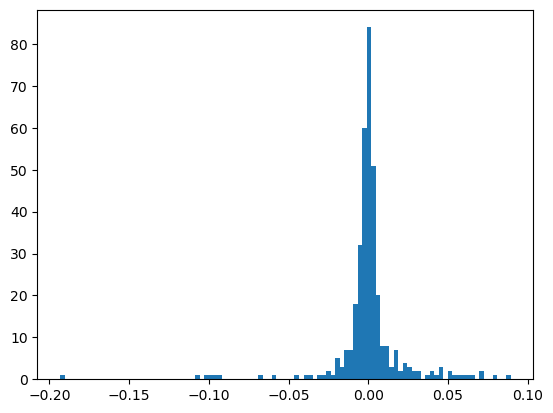

In [284]:
import matplotlib

i = 6
neuron = 1
#imin = np.min(np.concatenate([results2.jacobian[i][0,neuron,:].flatten() for i in range(start2, end2)]))
#imax = np.max(np.concatenate([results2.jacobian[i][0,neuron,:].flatten() for i in range(start2, end2)]))

stim = dataset[i]['stim'][0,:]

# get the Jacobians for the entire model
dstrf = results2.jacobian[i][0,neuron,:]
imin = torch.min(dstrf.flatten())
imax = torch.max(dstrf.flatten())

# get the predicted robs for neuron 0
pred = results2.pred[i-50:i+50, neuron]
robs = results2.robs[i-50:i+50, neuron]

_ = plt.hist(dstrf.flatten().detach().numpy(), bins=100)

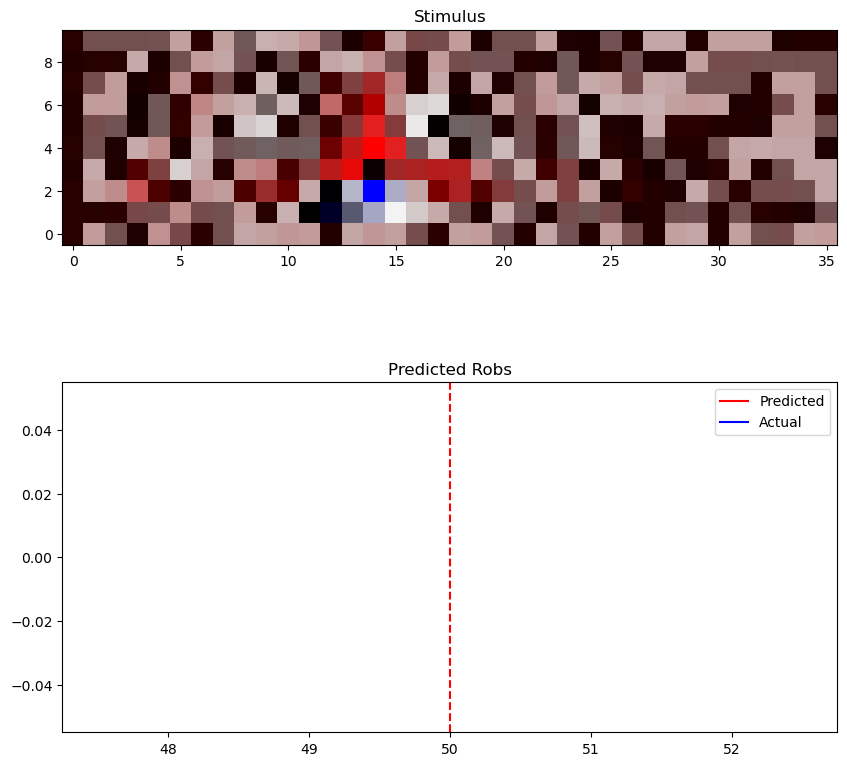

In [285]:
## make the plot for a single frame including stim, prediction, and dSTRF
rows = 2
cols = 1
fig = plt.figure(figsize=(10,10))
grid = plt.GridSpec(rows, cols)

ax_stim = fig.add_subplot(grid[0,:])
ax_stim.imshow(stim.detach().numpy().reshape(36,10).T,
               interpolation='none',
               cmap='gray',
               origin='lower')

c_blue = matplotlib.colors.colorConverter.to_rgba('blue',alpha = 1)
c_white = matplotlib.colors.colorConverter.to_rgba('black',alpha = 0)
c_red= matplotlib.colors.colorConverter.to_rgba('red',alpha = 1)
cmap_bwr = matplotlib.colors.LinearSegmentedColormap.from_list('bwr_cmap', [c_blue, c_white, c_red], 100)
ax_stim.imshow(dstrf.reshape(36,10).T,
                vmin=imin, vmax=imax,
                interpolation='none',
                cmap=cmap_bwr,
                origin='lower')
ax_stim.set_title('Stimulus')

ax_robs = fig.add_subplot(grid[1,:])
ax_robs.plot(pred, c='r')
ax_robs.plot(robs, c='b')
ax_robs.axvline(x=50, color='r', linestyle='--')
ax_robs.legend(['Predicted', 'Actual'], loc='upper right')
_ = ax_robs.set_title('Predicted Robs')

# ffmpeg requires that the digits start at 0
#plt.savefig(os.path.join('viz/dstrf', f'frame-{i-50:04d}.png'))
#plt.close(fig)

# clustering

In [161]:
len(dstrf_excs), len(dstrf_inhs)

(3, 3)

In [184]:
dstrf_excs_L2 = []
dstrf_inhs_L2 = []
stims = []
layer = 2
for i in range(start, end):
    # for time 0 and layer 0 of the core network
    # get the stims
    stim = dataset[i]['stim'][0,:]
    stims.append(stim.numpy())

    # get the Jacobians for the inhibitory and excitatory weights
    num_filters = model.networks[0].layers[layer].params['num_filters']
    num_inh = model.networks[0].layers[layer].params['num_inh']
    num_exc = num_filters - num_inh
    num_exc *= 36
    num_inh *= 36
    jacobian = results.jacobians[i]['core'][0]
    dstrf_exc = torch.mean(jacobian[0, :num_exc, :], axis=0)
    dstrf_inh = torch.mean(jacobian[0, num_exc:, :], axis=0)
    dstrf_excs_L2.append(dstrf_exc.numpy())
    dstrf_inhs_L2.append(dstrf_inh.numpy())

dstrf_excs_L2 = np.array(dstrf_excs_L2)
dstrf_inhs_L2 = np.array(dstrf_inhs_L2)
stims = np.array(stims)

In [185]:
dstrf_excs_L2.shape, dstrf_inhs_L2.shape, stims.shape

((500, 360), (500, 360), (500, 360))

In [189]:
import umap
import pickle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
reducer_excs = umap.UMAP()
scaled_R_excs = StandardScaler().fit_transform(dstrf_excs_L2)
dstrf_excs_embedding = reducer_excs.fit_transform(scaled_R_excs)

reducer_inhs = umap.UMAP()
scaled_R_inhs = StandardScaler().fit_transform(dstrf_inhs_L2)
dstrf_inhs_embedding = reducer_inhs.fit_transform(scaled_R_inhs)

reducer_stims = umap.UMAP()
scaled_stims = StandardScaler().fit_transform(stims)
stims_embedding = reducer_stims.fit_transform(scaled_stims)

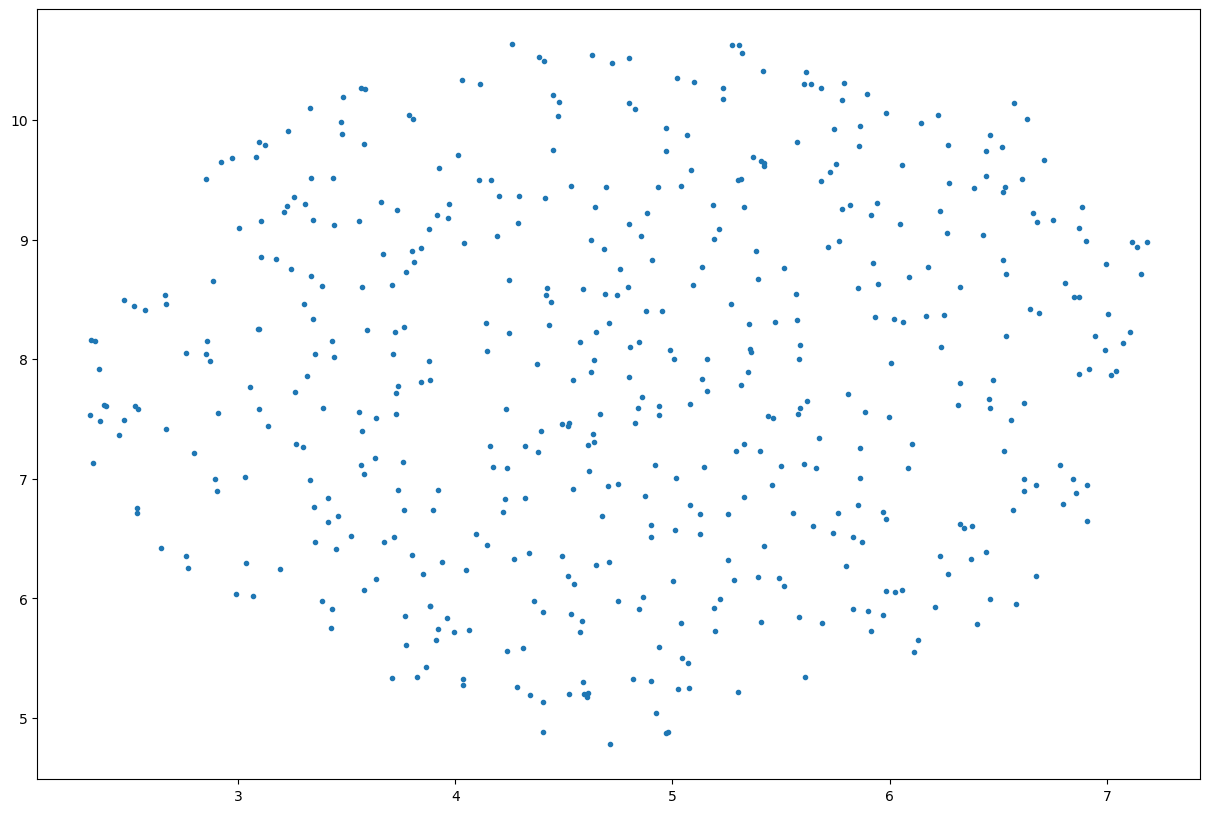

In [194]:
# plot it|
plt.figure(figsize=(15,10))
plt.scatter(dstrf_excs_embedding[:,0], dstrf_excs_embedding[:,1], 
            #c=range(500), cmap='rainbow', 
            marker='.')
plt.show()

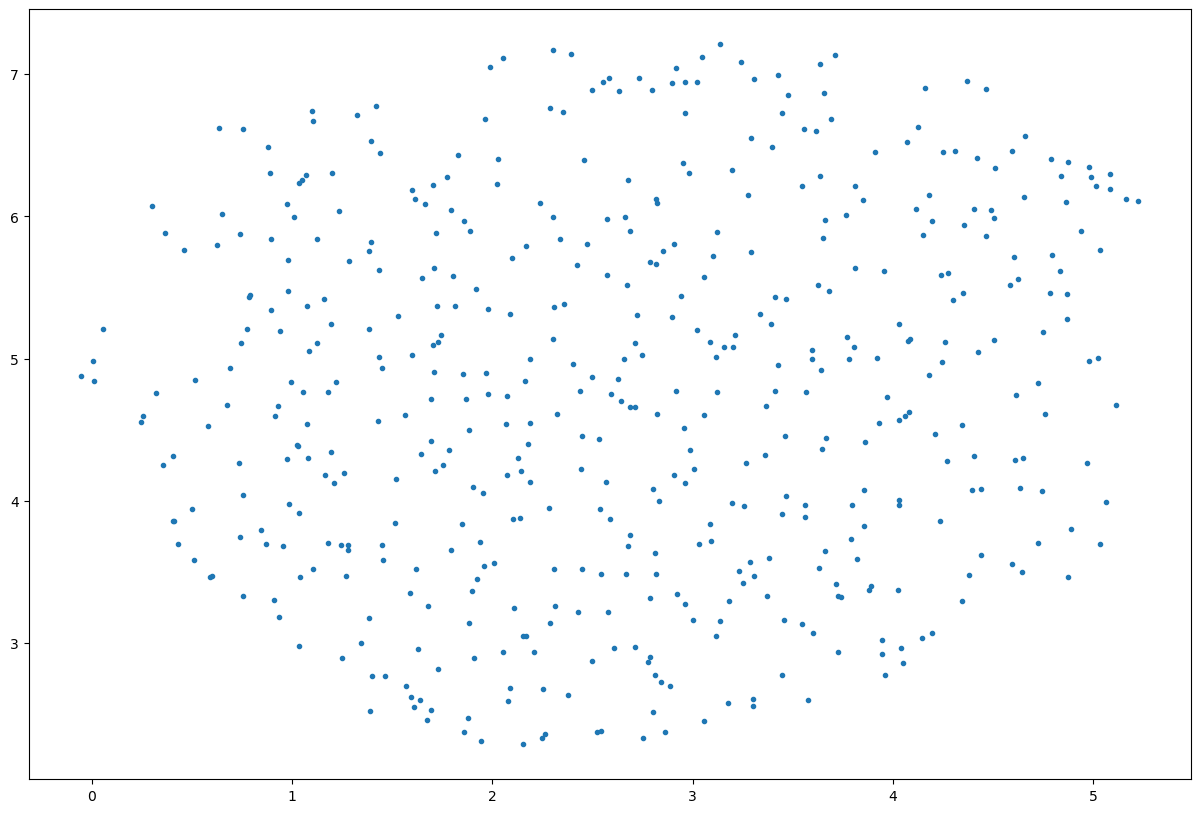

In [195]:
# plot it
plt.figure(figsize=(15,10))
plt.scatter(dstrf_inhs_embedding[:,0], dstrf_inhs_embedding[:,1], 
            #c=range(500), cmap='rainbow', 
            marker='.')
plt.show()

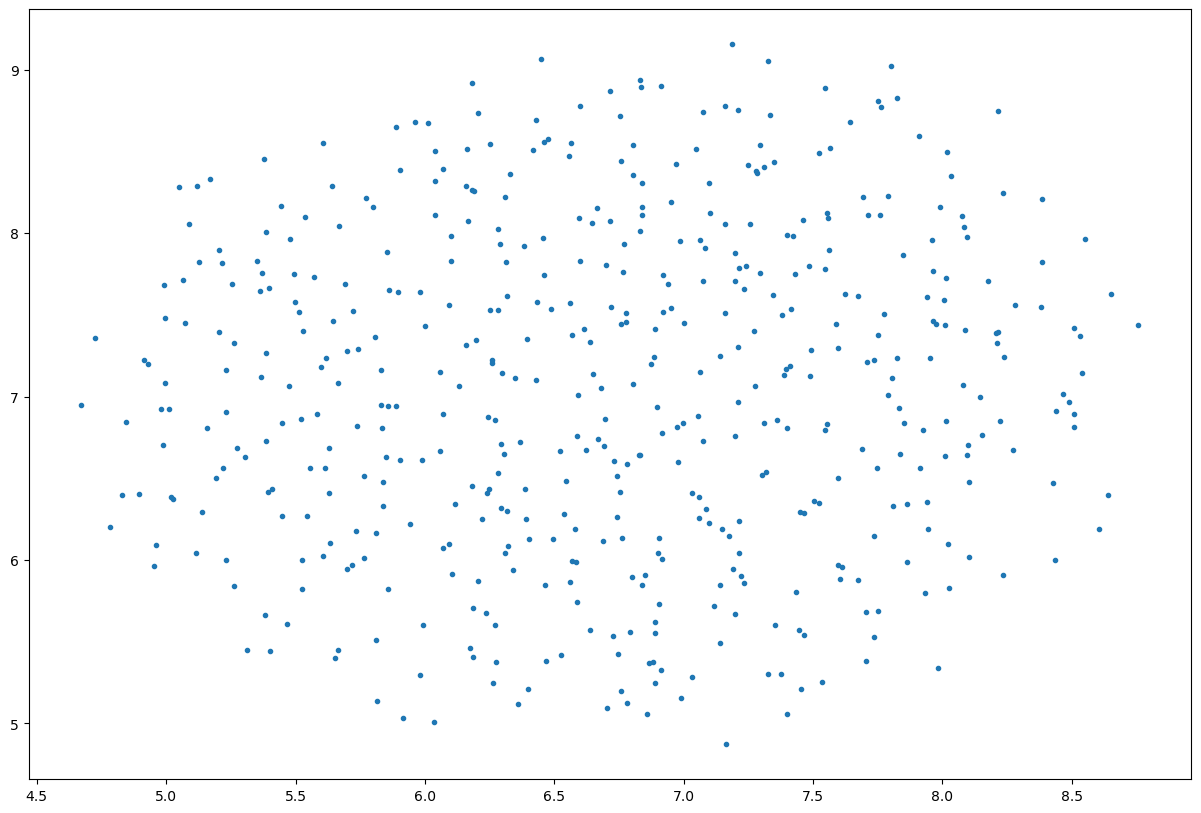

In [193]:
# plot stims
plt.figure(figsize=(15,10))
plt.scatter(stims_embedding[:,0], stims_embedding[:,1], 
            #c=range(500), cmap='rainbow', 
            marker='.')
plt.show()

# clustering for the whole model DSTRF

In [385]:
dstrfs = np.array([jac[0,neuron,:].detach().numpy() for jac in results2.jacobian])
dstrfs.shape

(600, 360)

In [299]:
# cluster the dstrfs using UMAP
import umap
reducer = umap.UMAP()
scaled_R = StandardScaler().fit_transform(dstrfs)
embedding = reducer.fit_transform(scaled_R)

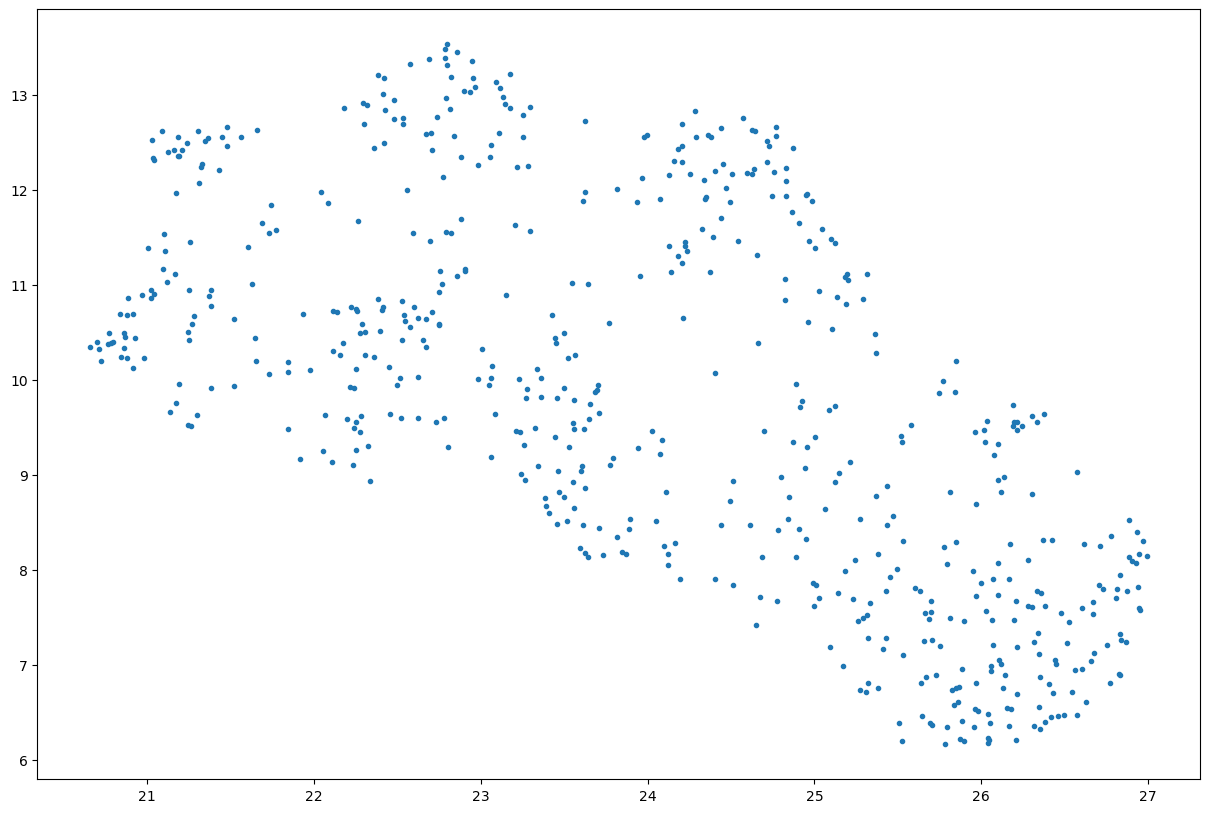

In [303]:
# plot the embedding
plt.figure(figsize=(15,10))
plt.scatter(embedding[:,0], embedding[:,1], marker='.')

In [313]:
import hdbscan
hdbscan_labels = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=10).fit_predict(embedding)
np.unique(hdbscan_labels)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7])

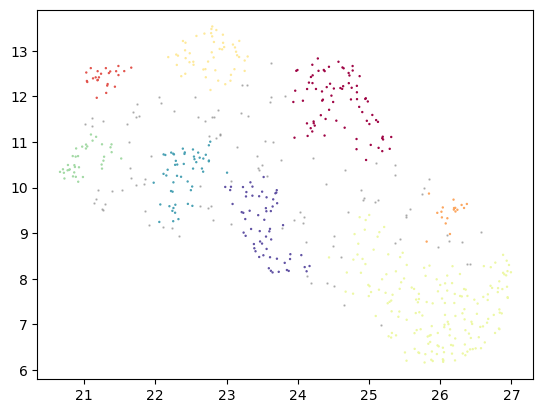

In [318]:
clustered = (hdbscan_labels >= 0)
plt.scatter(embedding[~clustered, 0],
            embedding[~clustered, 1],
            color=(0.5, 0.5, 0.5),
            s=0.5,
            alpha=0.5)
plt.scatter(embedding[clustered, 0],
            embedding[clustered, 1],
            c=hdbscan_labels[clustered],
            s=0.5,
            cmap='Spectral');

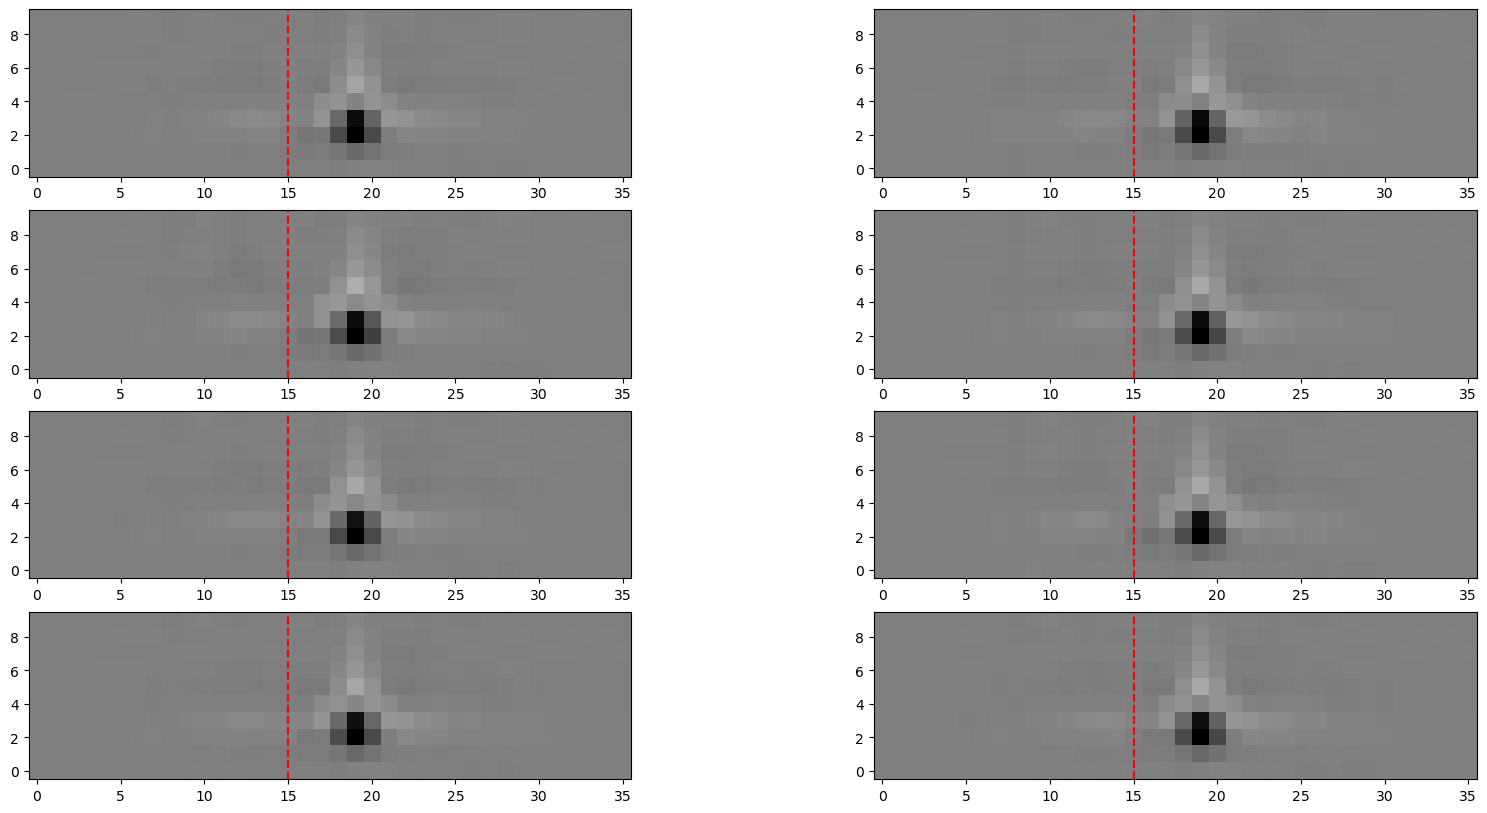

In [388]:
rows = 4
cols = 2
fig = plt.figure(figsize=(20,10))
grid = plt.GridSpec(rows, cols)
for label in range(np.max(hdbscan_labels)+1):
    row, col = np.unravel_index(label, (rows, cols))
    ax_cluster = fig.add_subplot(grid[row, col])
    mean = np.mean(dstrfs[hdbscan_labels == label], axis=0)
    imax = np.max(np.abs(mean))
    imin = -imax
    ax_cluster.imshow(np.mean(dstrfs[hdbscan_labels == label], axis=0).reshape(36,10).T,
           vmin=imin, vmax=imax,
           interpolation='none',
           cmap='gray',
       origin='lower')
    # draw a vertical line at point 15
    ax_cluster.axvline(x=15, color='r', linestyle='--')

# PCA

In [405]:
# print the number of neurons in the results2
num_neurons = len(results2.jacobian[0][0])
len(results2.jacobian)

600

In [408]:
# find the dstrfs for each neuron in the results2.jacobian
dstrfs_for_neurons = []
for neuron in range(29):
    dstrfs = np.array([jac[0,neuron,:].detach().numpy() for jac in results2.jacobian])
    dstrfs_for_neurons.append(dstrfs)
dstrfs_for_neurons = np.array(dstrfs_for_neurons)

In [409]:
dstrfs_for_neurons.shape

(29, 600, 360)

In [411]:
# find the principle components of the dstrfs for neuron 1
pca = PCA(n_components=10)
pca.fit(dstrfs_for_neurons[1,:,:])

PCA(n_components=10)

Text(0, 0.5, 'Explained Variance Ratio')

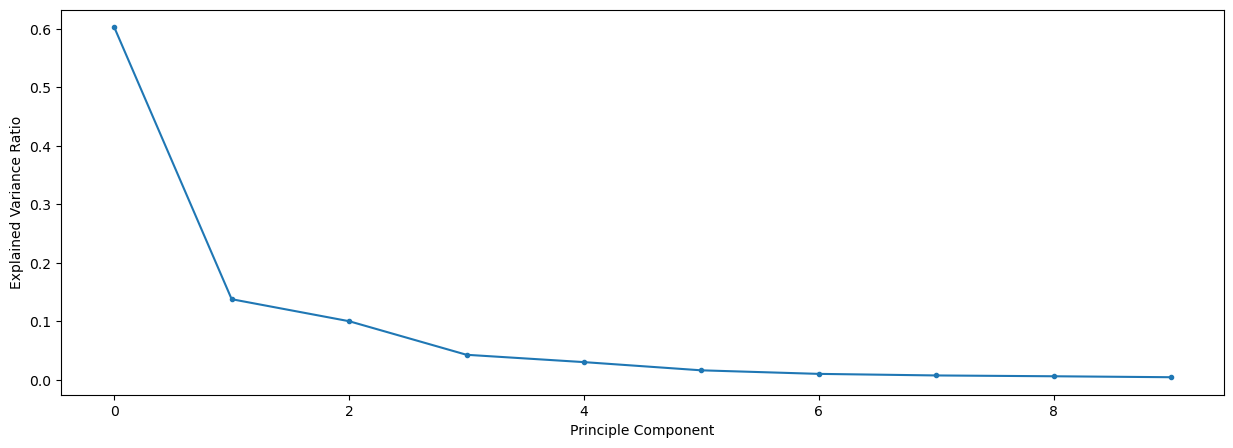

In [416]:
# plot the explained variance ratio
plt.figure(figsize=(15,5))
plt.plot(pca.explained_variance_ratio_, marker='.')
# label the axes
plt.xlabel('Principle Component')
plt.ylabel('Explained Variance Ratio')

In [425]:
# the explained variance ratio for the first 2 principle components is 74%
print('first 2 PCs sum', pca.explained_variance_ratio_[:2].sum()*100, '%')

# the explained variance ratio for the first 3 principle components is 84%
print('first 3 PCs sum', pca.explained_variance_ratio_[:3].sum()*100, '%')

# the explained variance ratio for the first 4 principle components is 88%
print('first 4 PCs sum', pca.explained_variance_ratio_[:4].sum()*100, '%')

# so, we can use the first 2-3 principle components to represent the dstrfs for neuron 1

first 2 PCs sum 74.04983639717102 %
first 3 PCs sum 84.08029675483704 %
first 4 PCs sum 88.3747398853302 %


In [433]:
# project the dstrfs for neuron 1 onto the first 2 principle components
proj_dstrfs1 = pca.transform(dstrfs_for_neurons[1,:,:])
proj_dstrfs1.shape

(600, 10)

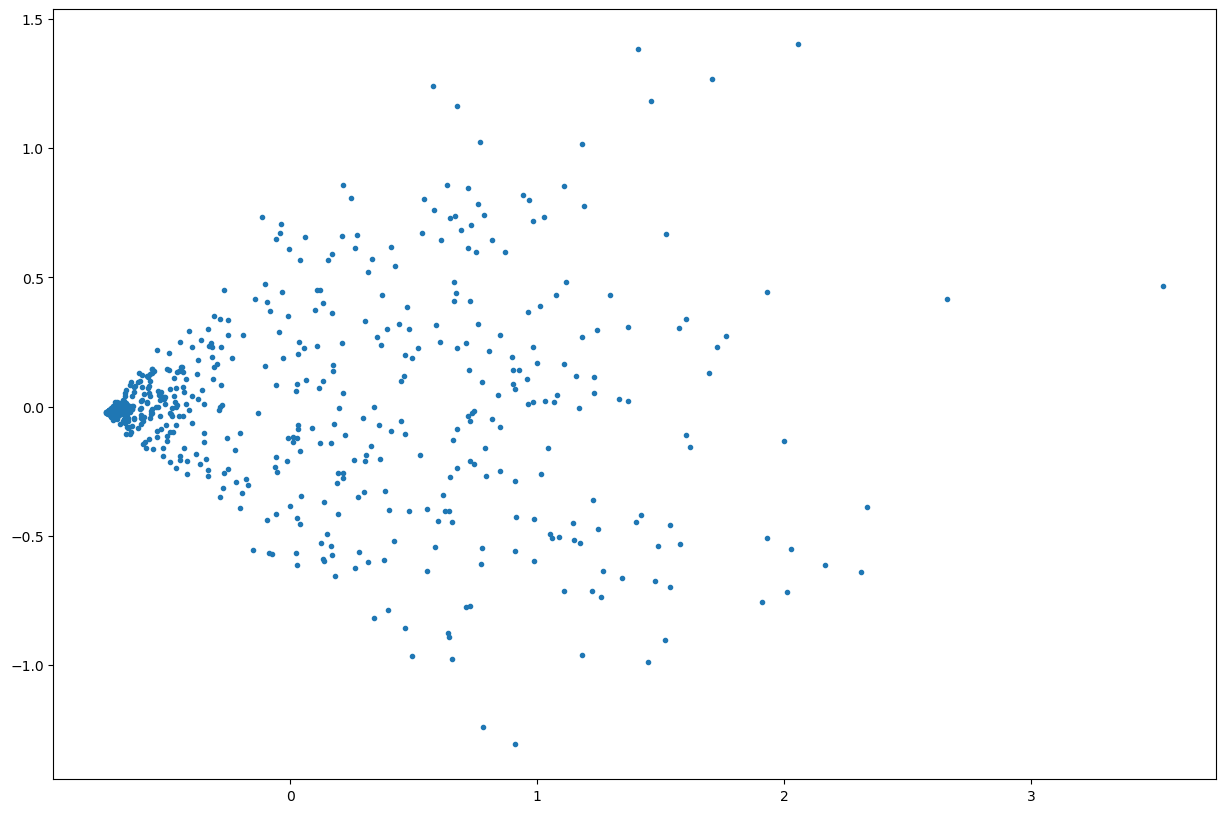

In [435]:
# plot the first 2 principle components of the dstrfs for neuron 1
plt.figure(figsize=(15,10))
plt.scatter(proj_dstrfs1[:,0], proj_dstrfs1[:,1], marker='.')

/home/mattjac/anaconda3/envs/pytorch/lib/python3.8/site-packages/matplotlib/collections.py:967: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


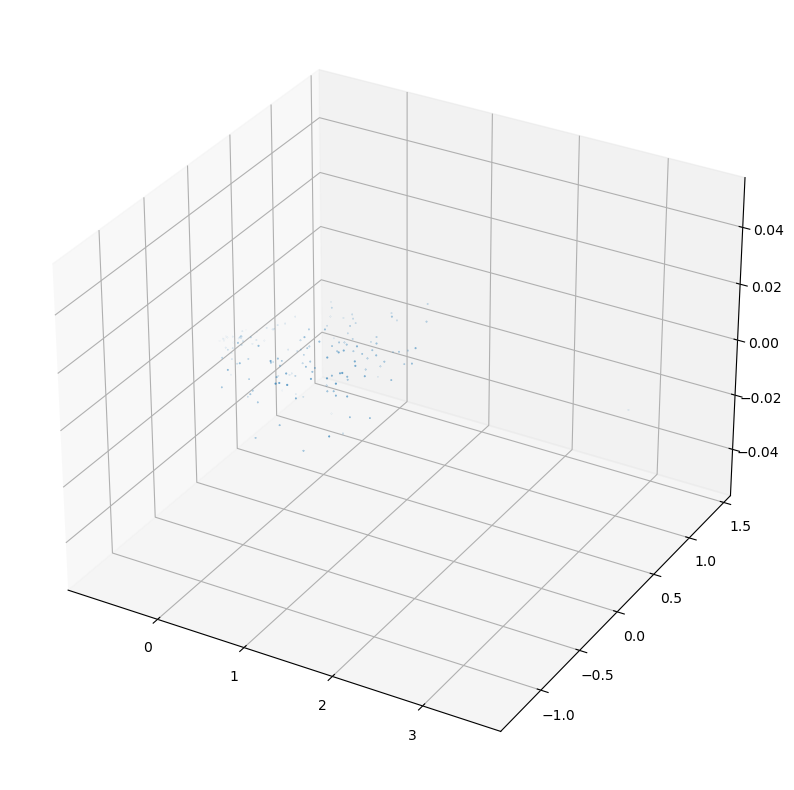

In [436]:
# plot the first 2 principle components of the dstrfs for neuron 1 in 3D
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
plt.scatter(proj_dstrfs1[:,0], proj_dstrfs1[:,1], proj_dstrfs1[:,2], marker='.')

[0 1 2 3 4 5 6 7 8 9]


(array([297.,  33.,  23.,  31.,  54.,  10.,  42.,  25.,  59.,  26.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

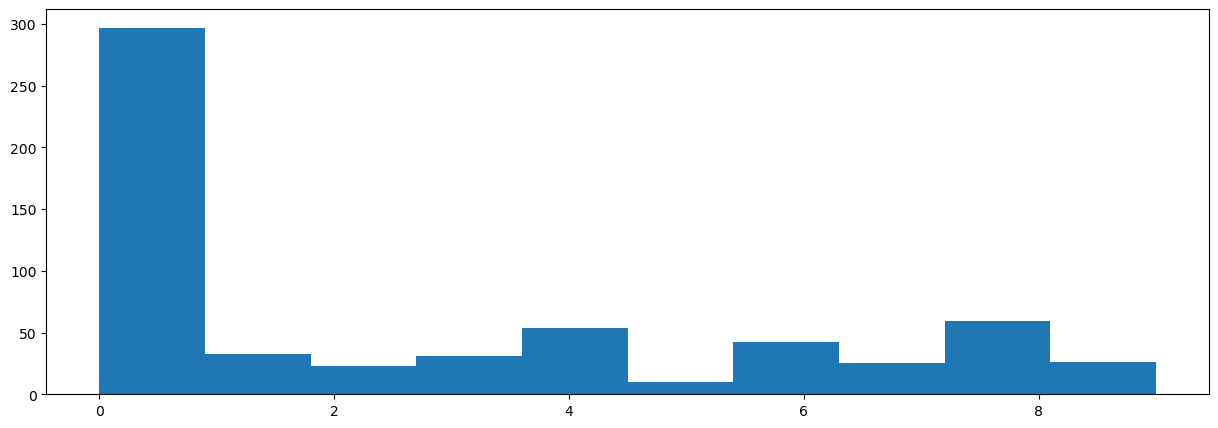

In [443]:
# cluster the dstrfs for neuron 1 using k-means
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=0).fit(dstrfs_for_neurons[1,:,:])
# print the unique labels
print(np.unique(kmeans.labels_))

# plot a histogram of the labels
plt.figure(figsize=(15,5))
plt.hist(kmeans.labels_, bins=10)

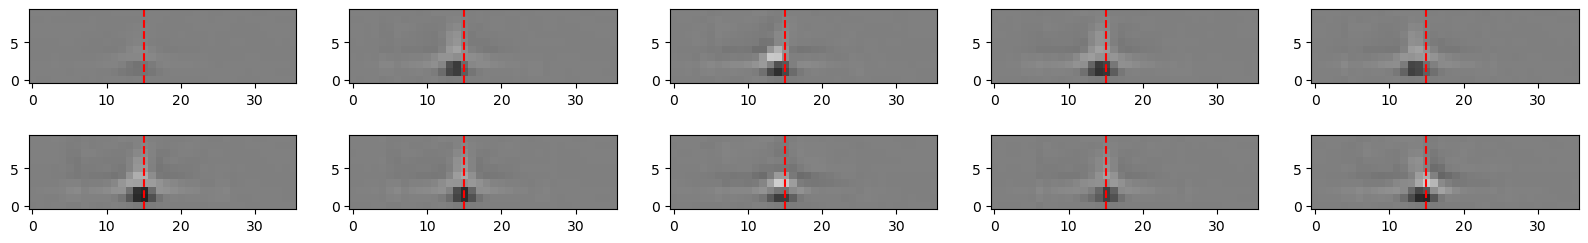

In [447]:
# plot some samples of the dstrfs for each cluster
rows = 2
cols = 5
fig = plt.figure(figsize=(20,3))
grid = plt.GridSpec(rows, cols)
for label in range(10):
    row, col = np.unravel_index(label, (rows, cols))
    ax_cluster = fig.add_subplot(grid[row, col])
    imax = np.max(np.abs(dstrfs_for_neurons[1, kmeans.labels_ == label, :]))
    imin = -imax
    ax_cluster.imshow(np.mean(dstrfs_for_neurons[1, kmeans.labels_ == label, :], axis=0).reshape(36,10).T,
           vmin=imin, vmax=imax,
           interpolation='none',
           cmap='gray',
       origin='lower')
    # draw a vertical line at point 15
    ax_cluster.axvline(x=15, color='r', linestyle='--')

Text(0, 0.5, 'Number of spikes')

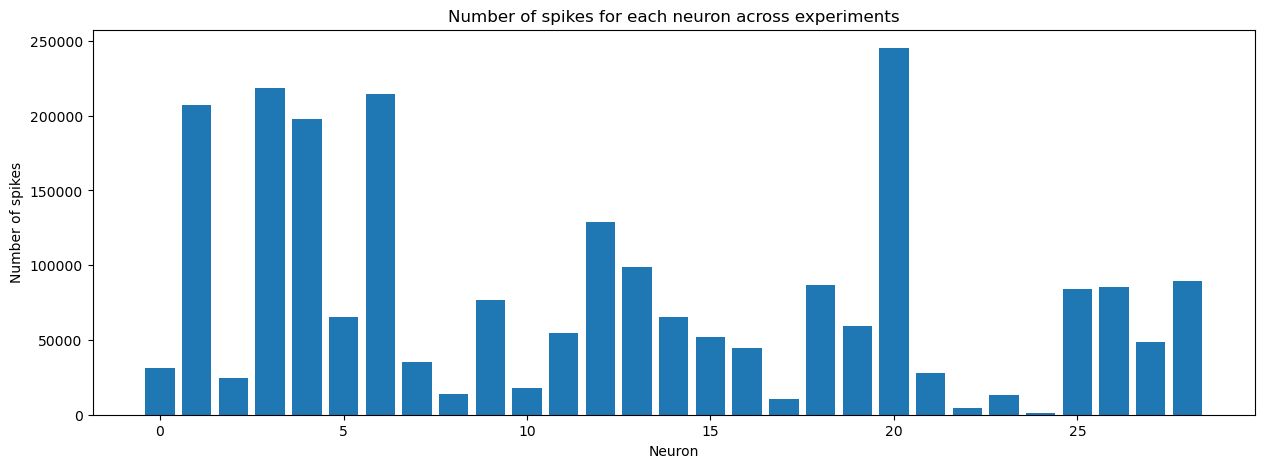

In [515]:
# get the number of spikes (robs > 0) for each neuron in the desired timerange in the dataset
num_spikes = torch.sum(dataset[:]['robs'], axis=0)

# plot it
plt.figure(figsize=(15,5))
plt.bar(np.arange(29), num_spikes)
plt.title('Number of spikes for each neuron across experiments')
plt.xlabel('Neuron')
plt.ylabel('Number of spikes')

Text(0, 0.5, 'r2')

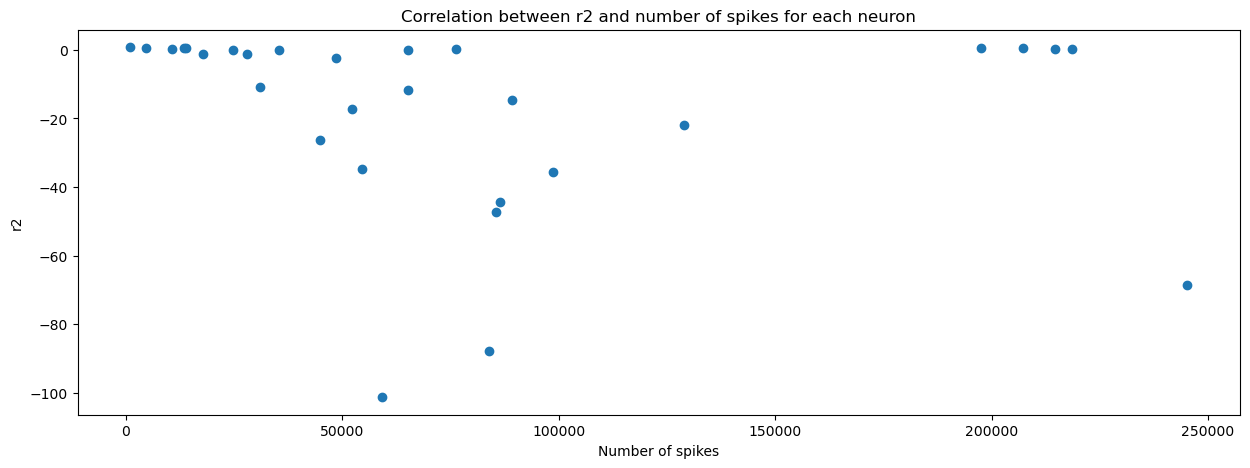

In [517]:
# show correlation between r2 and number of spikes for each neuron
plt.figure(figsize=(15,5))
plt.scatter(num_spikes, results2.r2)
plt.title('Correlation between r2 and number of spikes for each neuron')
plt.xlabel('Number of spikes')
plt.ylabel('r2')

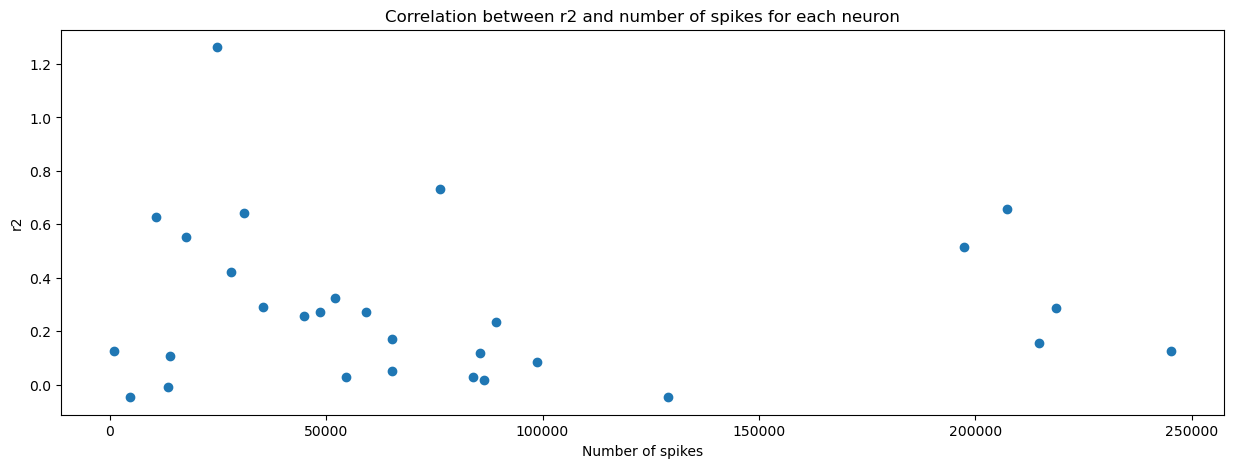

In [519]:
# show correlation between LLs and number of spikes for each neuron
plt.figure(figsize=(15,5))
plt.scatter(num_spikes, trial2.LLs)
plt.title('Correlation between r2 and number of spikes for each neuron')
plt.xlabel('Number of spikes')
_ = plt.ylabel('r2')

In [521]:
# how many neurons have spikes in the desired timerange?
num_spikes_in_range = torch.sum(dataset[start2-50:end2+50]['robs'], axis=0)
print('number of neurons with spikes in the desired timerange:', torch.sum(num_spikes_in_range > 0))

# print the neurons with spikes in the desired timerange
print('neurons with spikes in the desired timerange:', np.where(num_spikes_in_range > 0)[0])

number of neurons with spikes in the desired timerange: tensor(9)
neurons with spikes in the desired timerange: [1 2 3 4 5 6 7 8 9]


# filter out dstrfs for timepoints with no spikes

In [549]:
# find the dstrfs for each neuron in the results2.jacobian, but only for timepoints with spikes
# this is because we only calculated the Jacobian for timepoints from start2-50 to end2+50
# start2-50 = 0, end2+50 = 600
dstrfs_for_neurons_filtered = []
for neuron in range(1,10):
    dstrfs = np.array([jac[0,neuron,:].detach().numpy() for jac in results2.jacobian])
    # we will need to align the dstrfs with the dataset spike counts
    dstrfs = dstrfs[dataset[start2-50:end2+50]['robs'][:,neuron] > 0]
    dstrfs_for_neurons_filtered.append(dstrfs)

Text(0, 0.5, 'Number of neurons')

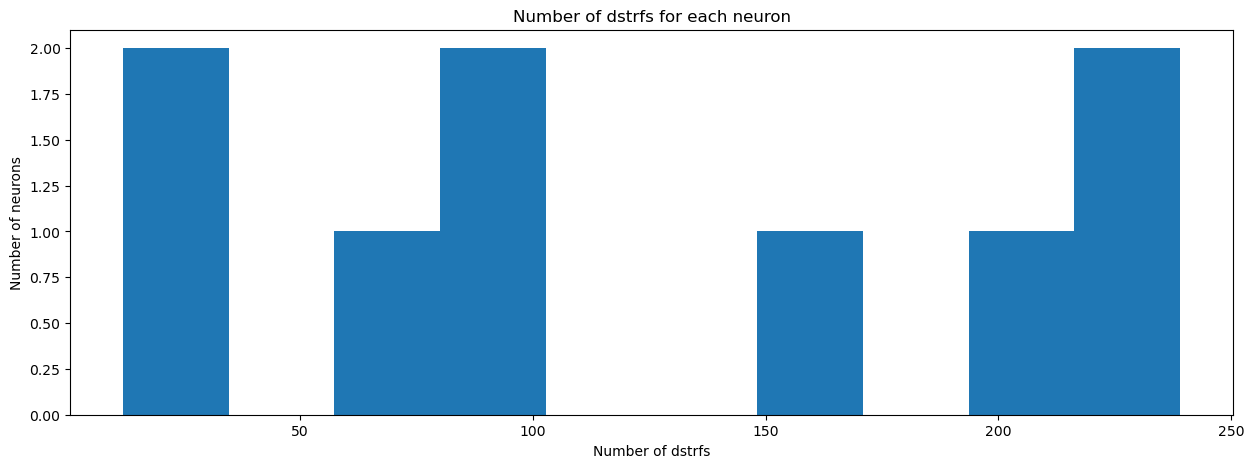

In [561]:
# plot the histogram of the number of dstrfs for each neuron
plot.lightmode()
plt.figure(figsize=(15,5))
plt.hist([dstrfs_for_neurons_filtered[neuron].shape[0] for neuron in range(0,9)], bins=10)
plt.title('Number of dstrfs for each neuron')
plt.xlabel('Number of dstrfs')
plt.ylabel('Number of neurons')

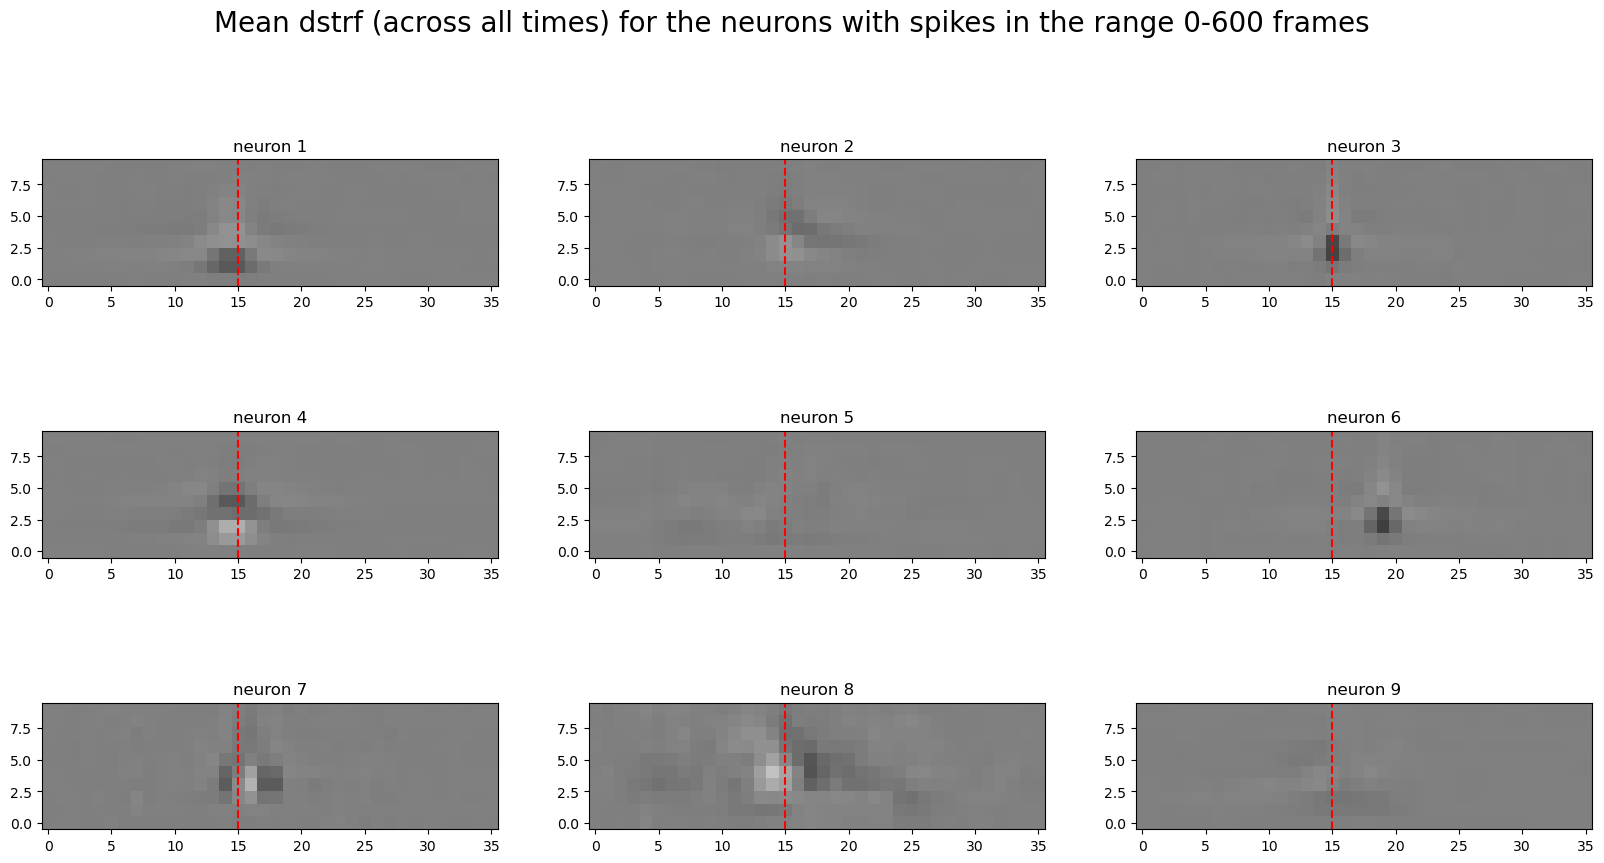

In [563]:
# plot the mean dstrf for each of the 9 neurons with spikes in the desired timerange
rows = 3
cols = 3
fig = plt.figure(figsize=(20,10))
grid = plt.GridSpec(rows, cols)
for neuron in range(0,9):
    row, col = np.unravel_index(neuron, (rows, cols))
    ax_cluster = fig.add_subplot(grid[row, col])
    imax = np.max(np.abs(dstrfs_for_neurons_filtered[neuron]))
    imin = -imax
    ax_cluster.imshow(np.mean(dstrfs_for_neurons_filtered[neuron], axis=0).reshape(36,10).T,
                      vmin=imin, vmax=imax,
                      interpolation='none',
                      cmap='gray',
                      origin='lower')
    # draw a vertical line at point 15
    ax_cluster.axvline(x=15, color='r', linestyle='--')
    ax_cluster.set_title('neuron ' + str(neuron+1))
# set the title
_ = fig.suptitle('Mean dstrf (across all times) for the neurons with spikes in the range 0-600 frames', fontsize=20)

/tmp/ipykernel_312805/3022373753.py:29: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=np.arange(0,num_colors,1))


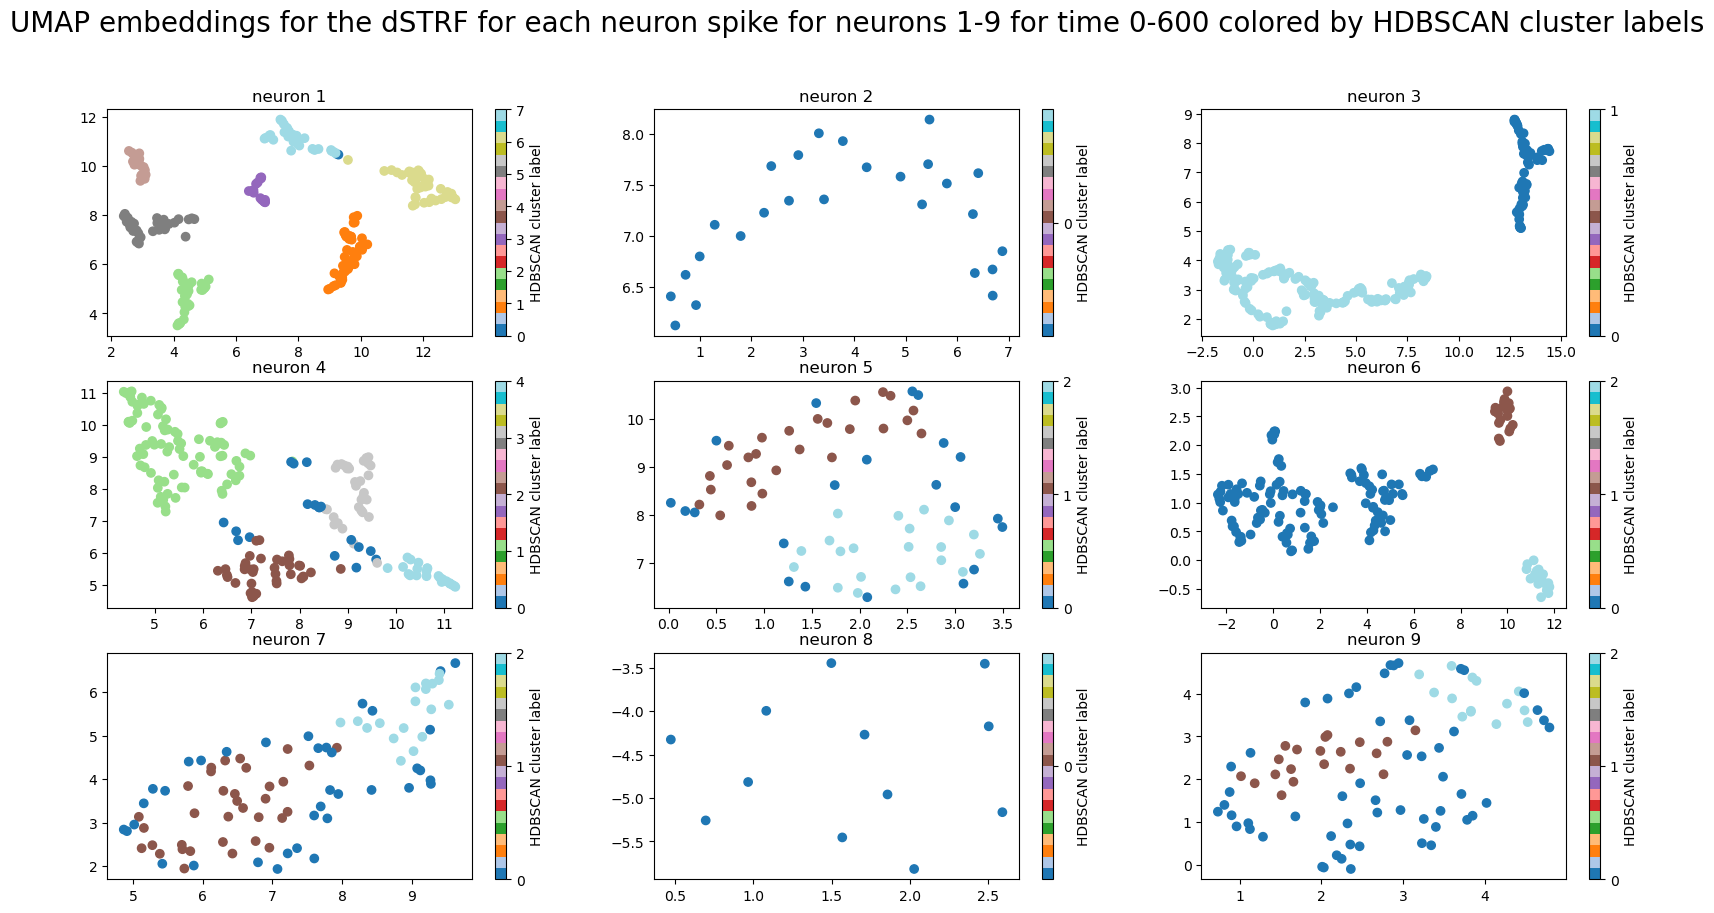

In [614]:
# UMAP the filtered dstrfs for each neuron
umap_embeddings = []
for neuron in range(0,9):
    reducer = umap.UMAP(n_neighbors=10, min_dist=0.0, n_components=2, random_state=42)
    embedding = reducer.fit_transform(dstrfs_for_neurons_filtered[neuron])
    umap_embeddings.append(embedding)

# cluster the UMAP embeddings for each neuron using HDBSCAN
hdbscan_labels = []
for neuron in range(0,9):
    clusterer = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=10)
    clusterer.fit(umap_embeddings[neuron])
    hdbscan_labels.append(clusterer.labels_)

/tmp/ipykernel_312805/3638054843.py:14: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=np.arange(0,num_colors,1))


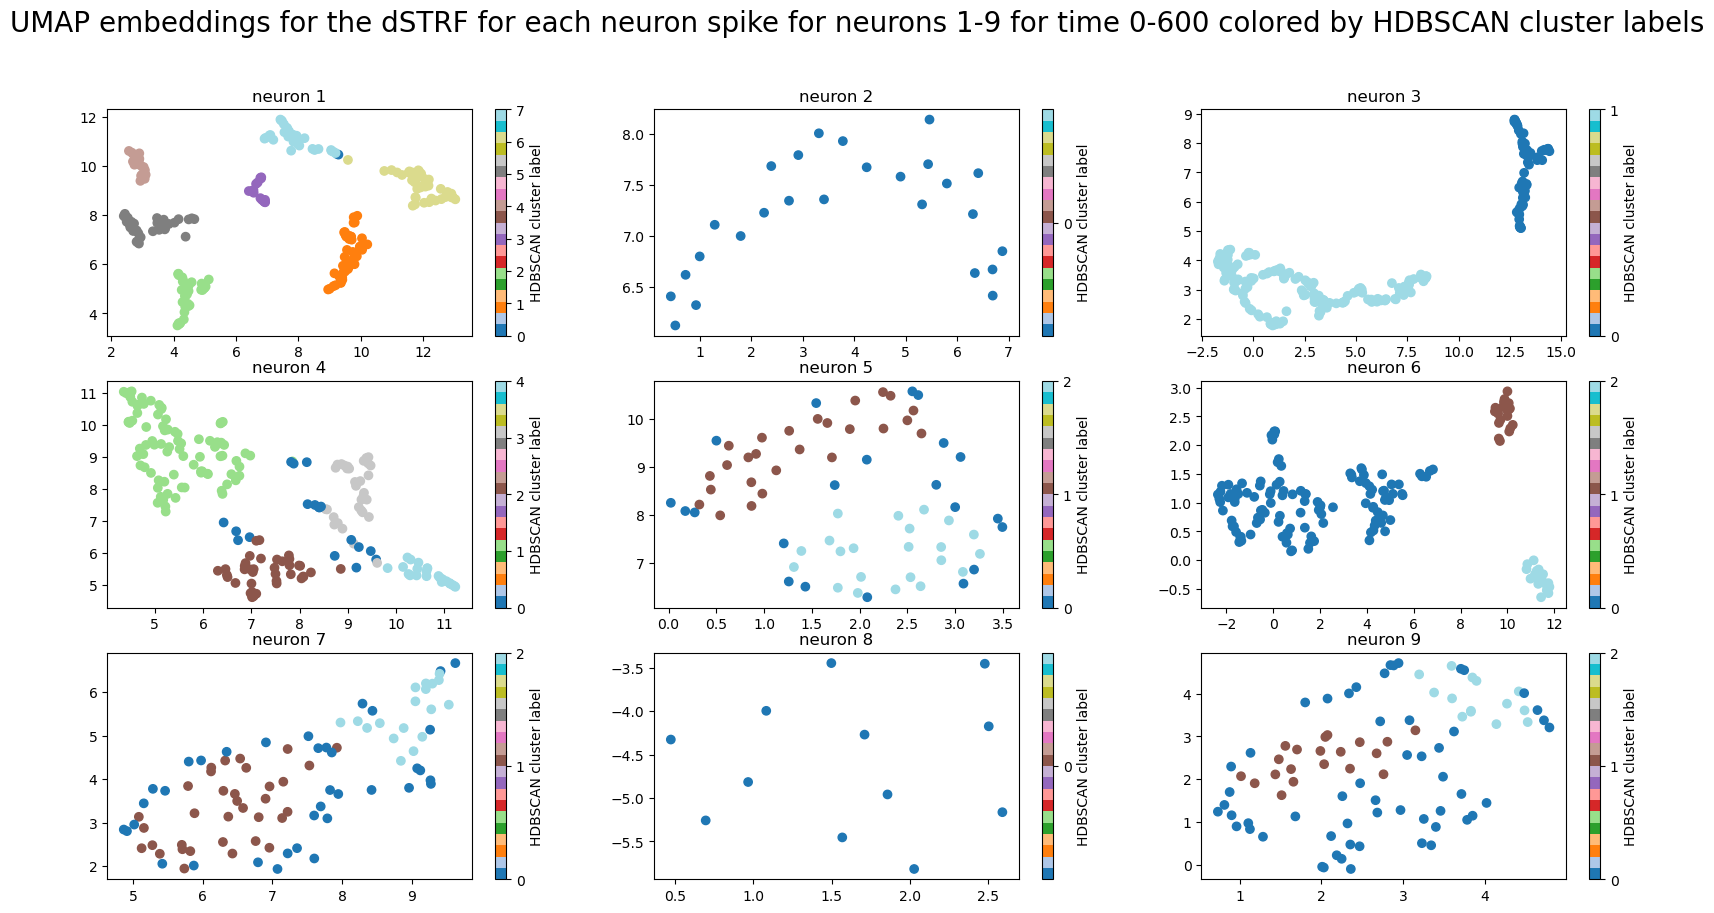

In [617]:
# plot the UMAP embeddings for each neuron
rows = 3
cols = 3
fig = plt.figure(figsize=(20,10))
grid = plt.GridSpec(rows, cols)
for neuron in range(0,9):
    row, col = np.unravel_index(neuron, (rows, cols))
    ax_cluster = fig.add_subplot(grid[row, col])
    ax_cluster.scatter(umap_embeddings[neuron][:,0], umap_embeddings[neuron][:,1], c=hdbscan_labels[neuron], cmap='tab20')
    ax_cluster.set_title('neuron ' + str(neuron+1))
    # draw the colormap legend
    num_colors = len(np.unique(hdbscan_labels[neuron]))
    sm = plt.cm.ScalarMappable(cmap='tab20', norm=plt.Normalize(vmin=0, vmax=num_colors-1))
    cbar = plt.colorbar(sm, ticks=np.arange(0,num_colors,1))
    cbar.ax.set_yticklabels(np.arange(0,num_colors,1))
    cbar.set_label('HDBSCAN cluster label')
_ = plt.suptitle('UMAP embeddings for the dSTRF for each neuron spike for neurons 1-9 for time 0-600 colored by HDBSCAN cluster labels', fontsize=20)

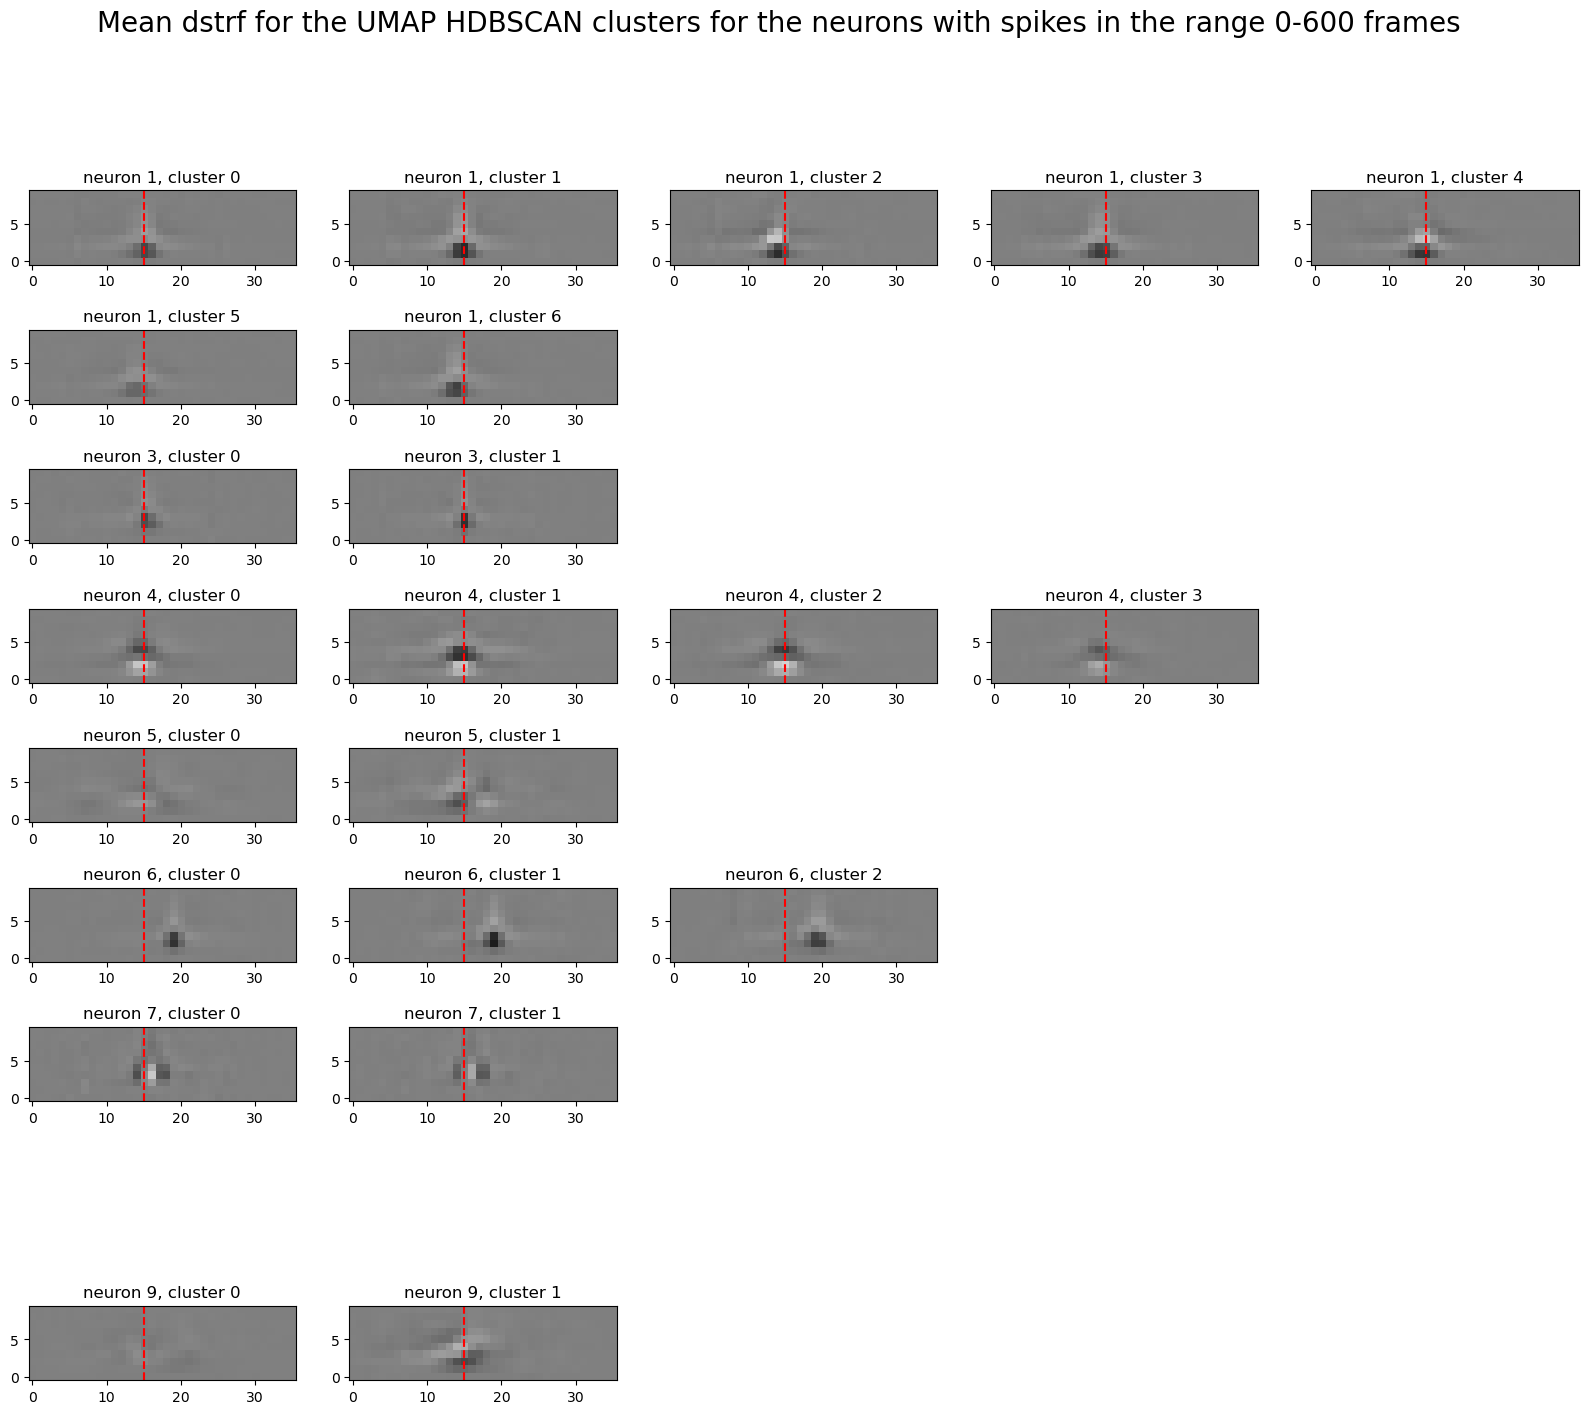

In [621]:
# plot the mean dstrf for each of the clusters for each neuron
rows = 9
cols = 5
fig = plt.figure(figsize=(20,16))
grid = plt.GridSpec(rows, cols)
for neuron in range(0,9):
    for cluster in [cluster for cluster in np.unique(hdbscan_labels[neuron]) if cluster != -1]:
        row, col = np.unravel_index(neuron*5+cluster, (rows, cols))
        ax_cluster = fig.add_subplot(grid[row, col])
        imax = np.max(np.abs(dstrfs_for_neurons_filtered[neuron][hdbscan_labels[neuron] == cluster]))
        imin = -imax
        ax_cluster.imshow(np.mean(dstrfs_for_neurons_filtered[neuron][hdbscan_labels[neuron] == cluster], axis=0).reshape(36,10).T,
                          vmin=imin, vmax=imax,
                          interpolation='none',
                          cmap='gray',
                          origin='lower')
        # draw a vertical line at point 15
        ax_cluster.axvline(x=15, color='r', linestyle='--')
        ax_cluster.set_title('neuron ' + str(neuron+1) + ', cluster ' + str(cluster))
# set the title
_ = fig.suptitle('Mean dstrf for the UMAP HDBSCAN clusters for the neurons with spikes in the range 0-600 frames', fontsize=20)

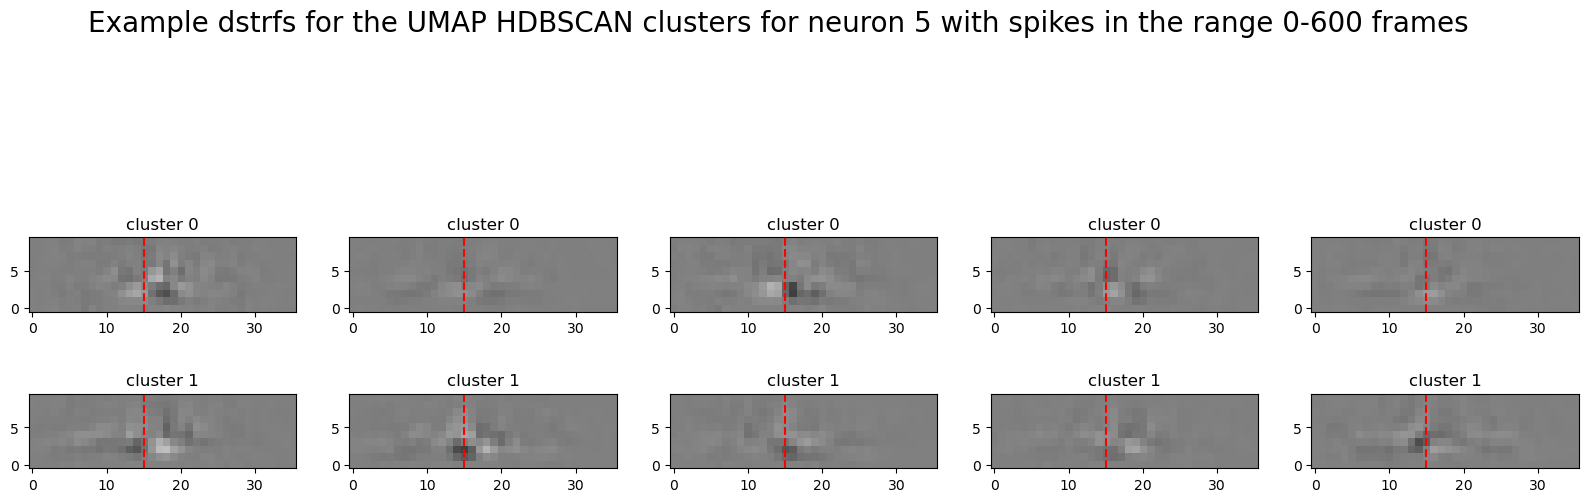

In [630]:
# plot a few example dstrfs (not means) from each cluster for neuron 1
neuron = 4
rows = 10
cols = 5
fig = plt.figure(figsize=(20,20))
grid = plt.GridSpec(rows, cols)
for cluster in [cluster for cluster in np.unique(hdbscan_labels[neuron]) if cluster != -1]:
    for i in range(0,5):
        row, col = np.unravel_index(cluster*5+i, (rows, cols))
        ax_cluster = fig.add_subplot(grid[row, col])
        imax = np.max(np.abs(dstrfs_for_neurons_filtered[neuron][hdbscan_labels[neuron] == cluster]))
        imin = -imax
        ax_cluster.imshow(dstrfs_for_neurons_filtered[neuron][hdbscan_labels[neuron] == cluster][i].reshape(36,10).T,
          vmin=imin, vmax=imax,
          interpolation='none',
          cmap='gray',
          origin='lower')
        # draw a vertical line at point 15
        ax_cluster.axvline(x=15, color='r', linestyle='--')
        ax_cluster.set_title('cluster ' + str(cluster))
# set the title
_ = fig.suptitle('Example dstrfs for the UMAP HDBSCAN clusters for neuron '+str(neuron+1)+' with spikes in the range 0-600 frames', fontsize=20)

Text(0.5, 1.0, 'Number of clusters for each neuron')

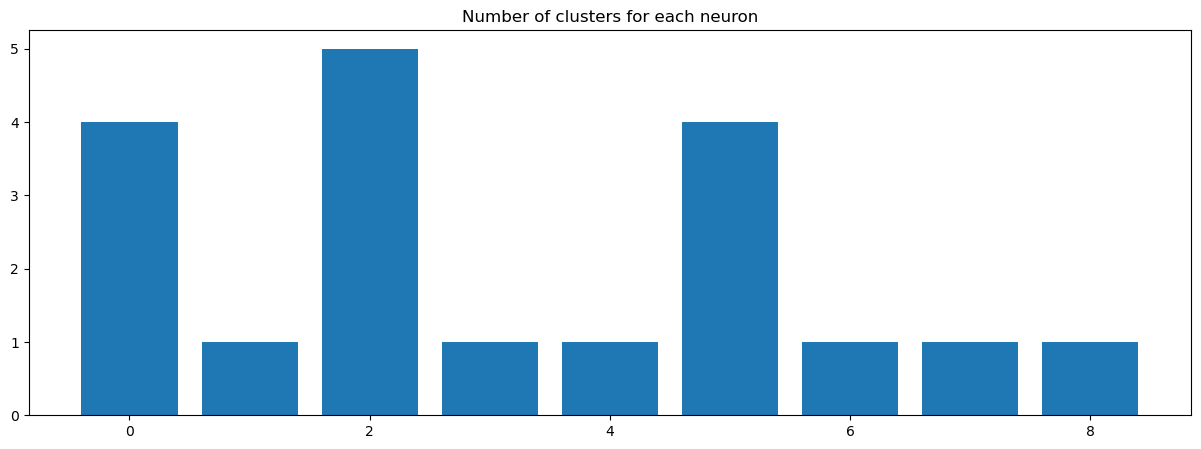

In [575]:
# HDBSCAN the filtered dstrfs for each neuron
hdbscan_labels = []
for neuron in range(0,9):
    clusterer = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=1)
    clusterer.fit(dstrfs_for_neurons_filtered[neuron])
    hdbscan_labels.append(clusterer.labels_)

# plot the number of clusters for each neuron
plot.lightmode()
plt.figure(figsize=(15,5))
plt.bar(np.arange(9), [len(np.unique(hdbscan_labels[neuron])) for neuron in range(0,9)])
plt.title('Number of clusters for each neuron')

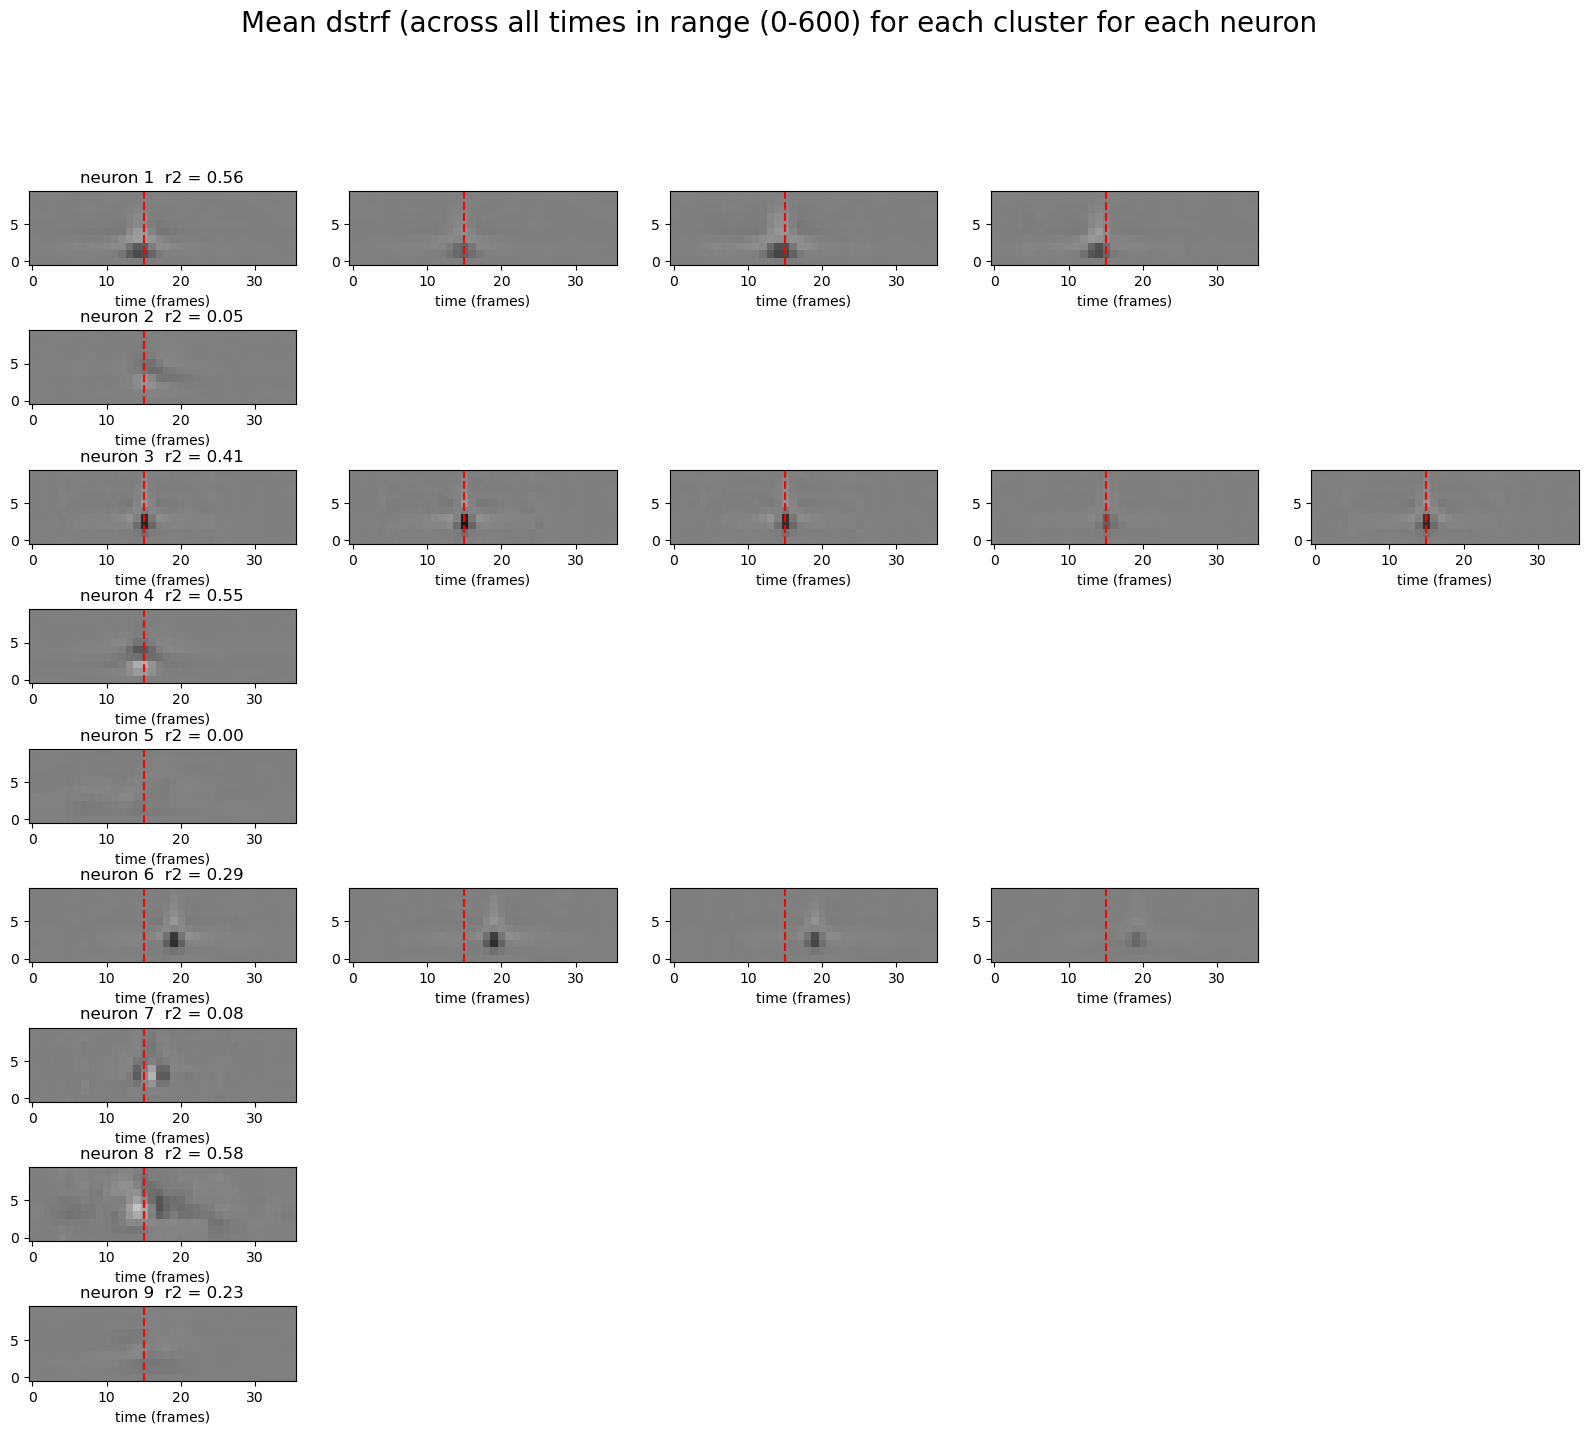

In [598]:
# plot the mean dstrf for each of the clusters for each neuron
rows = 9
cols = 5
fig = plt.figure(figsize=(20,16))
grid = plt.GridSpec(rows, cols)
for neuron in range(0,9):
    imax = np.max(np.abs(dstrfs_for_neurons_filtered[neuron]))
    imin = -imax
    for col, cluster in enumerate(np.unique(hdbscan_labels[neuron])):
        ax_cluster = fig.add_subplot(grid[neuron, col])
        ax_cluster.set_xlabel('time (frames)')
        if col == 0:
            r2 = results2.r2[neuron+1] # TODO: fix the +1 issue
            ax_cluster.set_title('neuron ' + str(neuron+1) + '  r2 = ' + str(f'{r2:.2f}'))
        ax_cluster.imshow(np.mean(dstrfs_for_neurons_filtered[neuron][hdbscan_labels[neuron] == cluster], axis=0).reshape(36,10).T,
                          vmin=imin, vmax=imax,
                          interpolation='none',
                          cmap='gray',
                          origin='lower')
        # draw a vertical line at point 15
        ax_cluster.axvline(x=15, color='r', linestyle='--')

_ = plt.suptitle('Mean dstrf (across all times in range (0-600) for each cluster for each neuron', fontsize=20)

# calculate the Jacobians for one of the subunits of the CNN

In [644]:
model.NDN.list_parameters()

Network 0:
  Layer 0:
      weight: torch.Size([210, 32])
  Layer 1:
      weight: torch.Size([672, 16])
  Layer 2:
      weight: torch.Size([336, 8])
Network 1:
  Layer 0:
      weight: torch.Size([2016, 29])
      bias: torch.Size([29])


In [648]:
# 21*32*16 = 10752
model.networks[0].layers[0].weights.shape, model.networks[0].layers[1].weights.shape, model.networks[0].layers[2].weights.shape

((21, 10, 32), (32, 21, 16), (16, 21, 8))

In [649]:
results2.jacobians[0]['core'][0].shape, results2.jacobians[0]['core'][1].shape, results2.jacobians[0]['core'][2].shape

(torch.Size([1, 1152, 360]),
 torch.Size([1, 576, 1152]),
 torch.Size([1, 288, 576]))

In [653]:
# look at the shape of the Jacobian for the second layer of the CNN
model.networks[0].layers[1].weights.shape, results2.jacobians[0]['core'][1].detach().cpu().numpy().shape

((32, 21, 16), (1, 576, 1152))

In [658]:
jac = results2.jacobians[0]['core'][1].detach().cpu().numpy()
jac.shape

(1, 576, 1152)

In [672]:
# TODO: we need to calculate the Jacobian from the input to the layer of interest,
#       not from the output of the previous layer to the input of the next layer

# 1152 / 32 = 36  # output of each subunit of the first layer
# 576 / 16 = 36  # output of each subunit of the second layer
(1152 * 576) / (36*32)

576.0

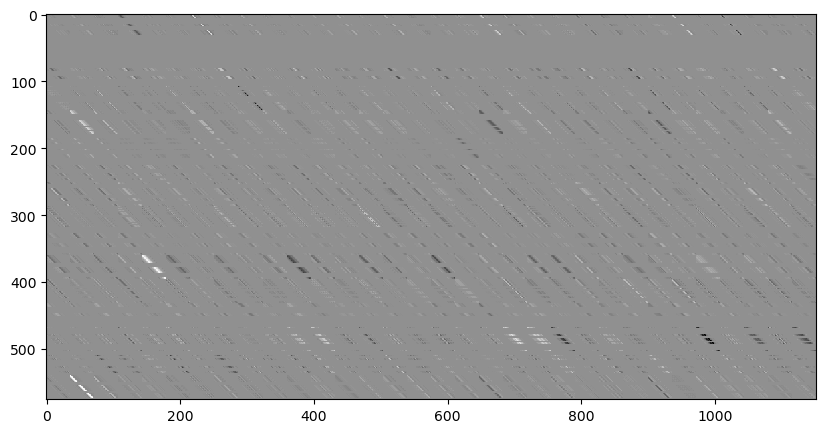

In [661]:
# plot the Jacobian for the second layer of the CNN
plot.lightmode()
plt.figure(figsize=(15,5))
plt.imshow(jac[0,:,:], cmap='gray', interpolation='none')

In [722]:
ni = 0
NT = 1000
inps = dataset[:NT]['stim']
all_jacobians = [{} for _ in range(len(inps))]
for inpi in range(len(inps)):
    all_jacobians[inpi][model.networks[ni].name] = []
for li in range(len(model.networks[ni].layers)):
    # calculate the Jacobian to get the DSTRF up through this layer
    def model_fx(x):
        with torch.cuda.amp.autocast():
            prev_z = x
            for lii in range(li+1):
                prev_z = model.NDN.networks[ni].layers[lii](prev_z)
            return prev_z
    for i in range(len(inps)): # for each input
        jacobian = torch.autograd.functional.jacobian(model_fx, inps[i], vectorize=True).cpu()
        all_jacobians[i][model.networks[ni].name].append(jacobian)

# plot the mean Jacobian for each of the subunits in each layer of the CNN

In [723]:

num_subunits = [32, 16, 8]
rows = 8
cols = 8
for t in range(0,NT):
    fig = plt.figure(figsize=(20,10))
    grid = plt.GridSpec(rows, cols)
    i = 0
    # plot the stim for the current time
    ax_stim = fig.add_subplot(grid[0, :])
    ax_stim.imshow(inps[t].reshape(36,10).T, interpolation='none', cmap='gray', origin='lower')
    ax_stim.set_title('stimulus')
    for l in range(3):
        for u in range(num_subunits[l]):
            ax_cluster = fig.add_subplot(grid[i//cols+1, i%cols])
            subunit_jacobian = all_jacobians[t][model.networks[ni].name][l][0,36*u:36*(u+1),:]
            imax = torch.max(torch.abs(subunit_jacobian))
            imin = -imax
            ax_cluster.imshow(torch.mean(subunit_jacobian, axis=0).reshape(36,10).T,
                              vmin=imin, vmax=imax,
                              interpolation='none',
                              cmap='gray',
                              origin='lower')
            # draw a vertical line at point 15
            ax_cluster.axvline(x=15, color='r', linestyle='--')
            ax_cluster.set_title('layer ' + str(l) + ' - subunit ' + str(u+1))
            i += 1
    
    # ffmpeg requires that the digits start at 0
    plt.savefig(os.path.join('viz/dstrfs_layers', f'frame-{t:04d}.png'))
    plt.close(fig)

# generate the video
import ffmpeg
ffmpeg.input(
    f'viz/dstrfs_layers/frame-%04d.png', framerate=10
).output(
    'dstrfs_layers.mp4', r=60, pix_fmt='yuv420p'
).run(
    overwrite_output=True
)

ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/tmp/build/80754af9/ffmpeg_1587154242452/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100


(None, None)

# plot the middle Jacobian for each of the subunits in each layer of the CNN

In [23]:
start = 0
end = 1000
results = predict.predict(model,
                          dataset=dataset[start:end],
                          network_names_to_use=['core'])

In [24]:
import tqdm

inps = dataset.stim[start:end]

imins = []
imaxs = []
for l in range(3):
    imins.append(np.min(np.concatenate([results.jacobians[t]['core'][l][0,:].flatten() for i in range(start, end)])))
    imaxs.append(np.max(np.concatenate([results.jacobians[t]['core'][l][0,:,:].flatten() for i in range(start, end)])))

print(imins, imaxs)

[-0.7096428, -0.85814863, -0.7658665] [0.5378149, 1.0664781, 0.72952026]


In [0]:
num_subunits = [32, 16, 8]
rows = 8
cols = 8
for t in tqdm.tqdm(range(start, end)):
    fig = plt.figure(figsize=(20,10))
    grid = plt.GridSpec(rows, cols)
    i = 0
    # plot the stim for the current time
    ax_stim = fig.add_subplot(grid[0, :])
    ax_stim.imshow(inps[t].reshape(36,10).T, interpolation='none', cmap='gray', origin='lower')
    ax_stim.set_title('stimulus')
    for l in range(3):
        for u in range(num_subunits[l]):
            ax_cluster = fig.add_subplot(grid[i//cols+1, i%cols])
            subunit_jacobian = results.jacobians[t]['core'][l][0,36*u:36*(u+1),:]
            ax_cluster.imshow(subunit_jacobian[15].reshape(36,10).T,
                              vmin=imins[l], vmax=imaxs[l],
                              interpolation='none',
                              cmap='gray',
                              origin='lower')
            # draw a vertical line at point 15
            ax_cluster.axvline(x=15, color='r', linestyle='--')
            ax_cluster.set_title('layer ' + str(l) + ' - subunit ' + str(u+1))
            i += 1

    # ffmpeg requires that the digits start at 0
    plt.savefig(os.path.join('viz/dstrfs_layers2', f'frame-{t:04d}.png'))
    plt.close(fig)

In [26]:
# generate the video
import ffmpeg
ffmpeg.input(
    f'viz/dstrfs_layers2/frame-%04d.png', framerate=5
).output(
    'viz/dstrfs_layers2.mp4', r=60, pix_fmt='yuv420p'
).run(
    overwrite_output=True
)

ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/tmp/build/80754af9/ffmpeg_1587154242452/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100


(None, None)

In [61]:
# get the middle Jacobian for each of the subunits in each layer of the CNN
subunit_jacobians = []
for t in tqdm.tqdm(range(start, end)):
    for l in range(3):
        subunit_jacobians.append([])
        for u in range(num_subunits[l]):
            subunit_jacobian = results.jacobians[t]['core'][l][0,36*u:36*(u+1),:][15]
            subunit_jacobians[l].append(subunit_jacobian.detach().cpu().numpy())

# # normalize (z-score) the subunit Jacobians
# for l in range(3):
#     subunit_jacobian = np.array(subunit_jacobians[l])
#     subunit_jacobians[l] = (subunit_jacobian - np.mean(subunit_jacobian, axis=0)) / np.std(subunit_jacobian, axis=0)

100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3094.66it/s]


# cluster the Jacobians for a layer of the CNN using UMAP

In [64]:
num_units = 32
layer = 0

# get the Jacobians for the last layer of the CNN
jacobians = subunit_jacobians[layer]

# are there any NaNs?
np.isnan(jacobians).any()

False

In [65]:
# reduce the dimensionality of the Jacobians across units using UMAP
import umap
from sklearn.preprocessing import StandardScaler
reducer = umap.UMAP(n_components=2, n_neighbors=10, min_dist=0.1, metric='correlation')
# scale the Jacobians using the StandardScaler
jacobians_scaled = StandardScaler().fit_transform(jacobians)
embedding = reducer.fit_transform(jacobians_scaled)
print(embedding.shape)

(32000, 2)


32000


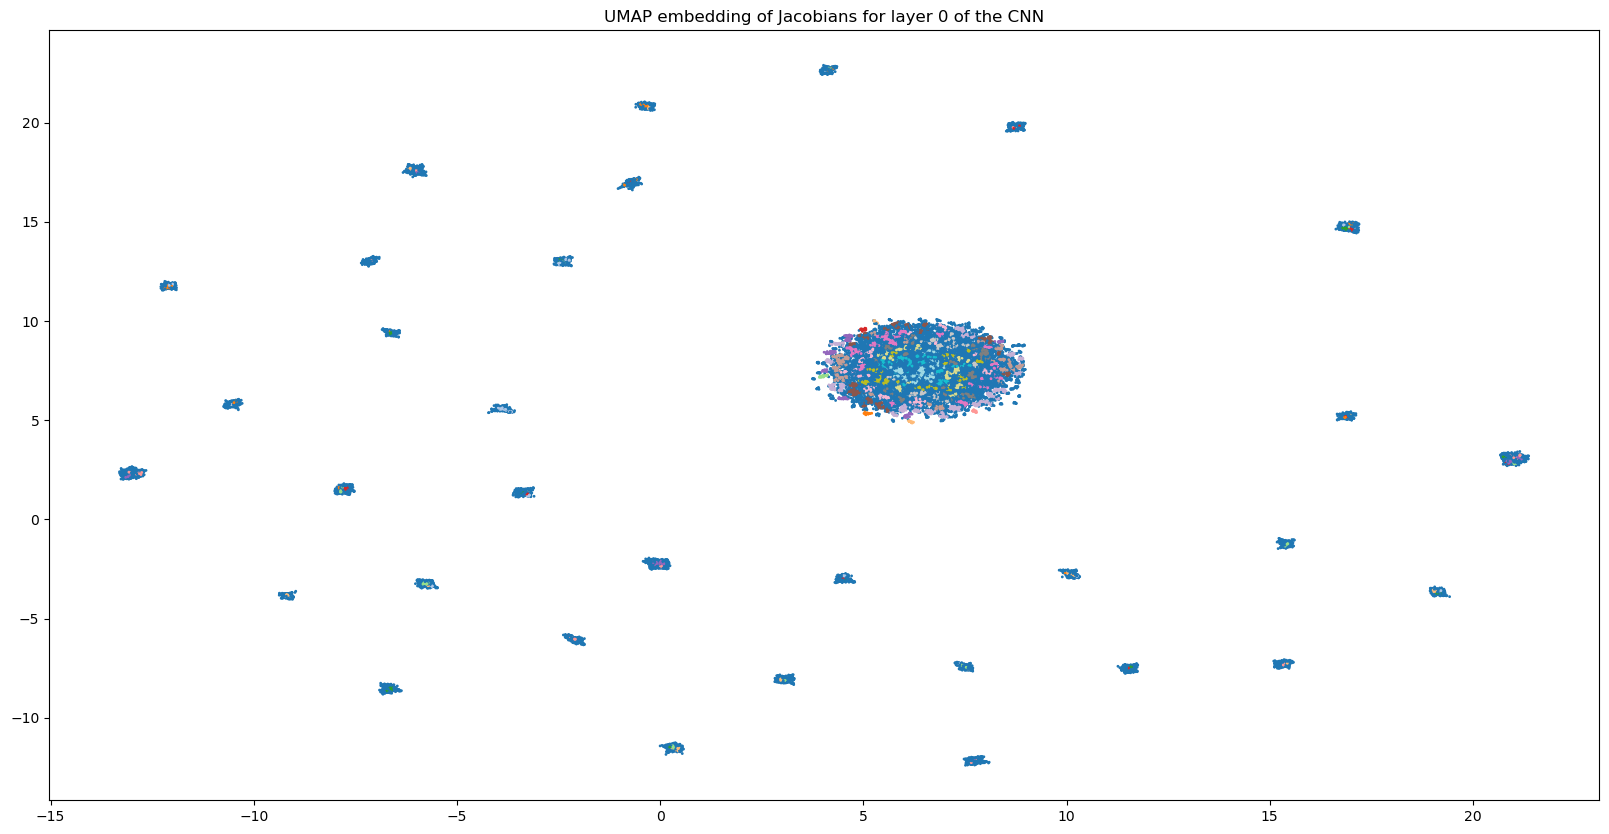

In [67]:
import hdbscan
# cluster the embeddings using HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=10, metric='euclidean', cluster_selection_method='leaf')
clusterer.fit(embedding)
cluster_labels = clusterer.labels_

# plot the UMAP embeddings
plot.lightmode()
plt.figure(figsize=(20,10))
_ = plt.scatter(embedding[:,0], embedding[:,1], s=1, c=cluster_labels, cmap='tab20')
plt.title('UMAP embedding of Jacobians for layer ' + str(layer) + ' of the CNN')

print(len(cluster_labels))

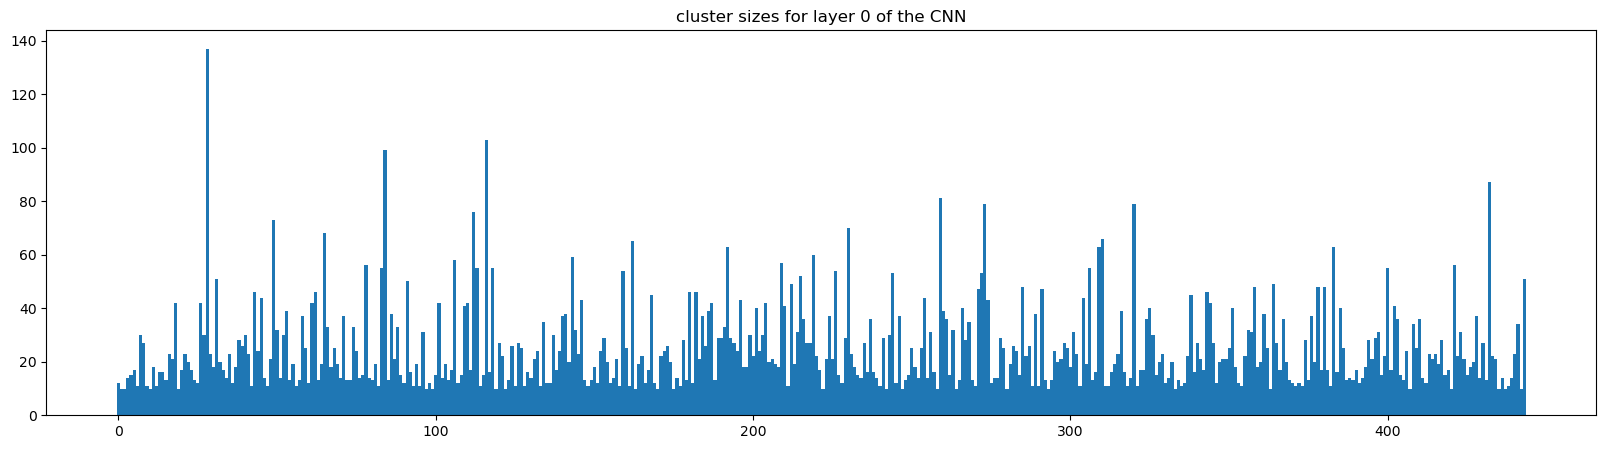

In [68]:
# plot a histogram of the sizes of the clusters
plot.lightmode()
plt.figure(figsize=(20,5))
plt.hist(cluster_labels, bins=np.arange(np.max(cluster_labels)+2)-0.5)
_ = plt.title('cluster sizes for layer ' + str(layer) + ' of the CNN')

In [69]:
# filter the clusters to only keep the ones with greater than 60 points
min_size = 60
cluster_sizes = np.array([np.sum(cluster_labels==c) for c in range(np.max(cluster_labels)+1)])
filtered_cluster_labels = np.arange(np.max(cluster_labels)+1)[cluster_sizes>min_size]
np.unique(filtered_cluster_labels)

array([ 28,  49,  65,  84, 112, 116, 162, 192, 230, 259, 273, 309, 310,
       320, 383, 432])

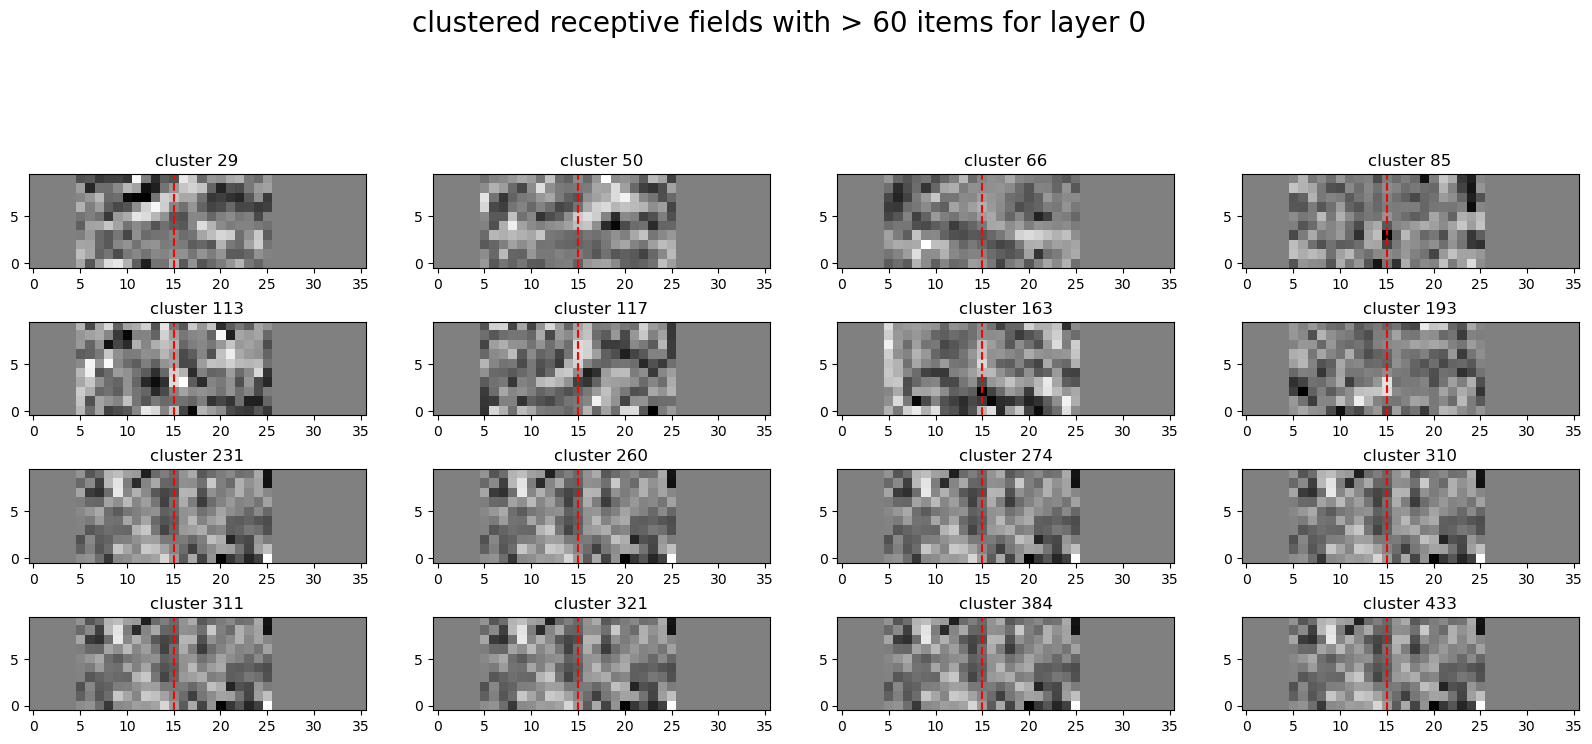

In [76]:
# plot the mean DSTRF for each cluster
# I guess we can't really just look at the clusters across subunits,
# because it doesn't tell us much.
plot.lightmode()
plt.figure(figsize=(20,15))
grid = plt.GridSpec(8, 4)
for c in range(len(filtered_cluster_labels)):
    label = filtered_cluster_labels[c]
    ax_cluster = plt.subplot(grid[c//4, c%4])
    cluster_jacobians = jacobians_scaled[cluster_labels==label,:]
    imax = np.max(np.abs(cluster_jacobians))
    imin = -imax
    ax_cluster.imshow(np.mean(cluster_jacobians, axis=0).reshape(36,10).T,
                      vmin=imin, vmax=imax,
                      interpolation='none',
                      cmap='gray',
                      origin='lower')
    # draw a vertical line at point 15
    ax_cluster.axvline(x=15, color='r', linestyle='--')
    ax_cluster.set_title('cluster ' + str(label+1))
_ = plt.suptitle('clustered receptive fields with > 60 items for layer ' + str(layer), fontsize=20)